# Abstract
Real estate is one of the oldest and most important industry in the world and housing is one of the most important aspects of real estate. The housing prices have changed drastically, especially in the modern times. There are many factors such as location, area, number of rooms, etc which can impact the price of a house.

The Paris Housing dataset consists of:

* 16 characteristics of houses such as area in sq. meters, number of rooms, 
number of previous owners, availability of attic, garage, etc.
* The dependent variable - Price.
* There are approximately 10,000 records in the dataset.

The purpose of this notebook is to:
* Examine the dataset to answer questions regarding the distribution of data for each of the variables, multicollinearity in the dataset, missing values and feature importance.
* Use H2O.ai's AutoML library for building a model on the Paris Housing dataset.
* Use Linear Regression, Decision Trees and H2O.ai's AutoML library for the purpose of interpreting the models using SHAP, PDP and LIME analysis.

In [1]:
from google.colab.output import eval_js
eval_js('google.colab.output.setIframeHeight("300")')

In [ ]:
#Installing dependencies
!pip install eli5
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install shap
!pip install lime
!pip install treeinterpreter
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

In [3]:
#Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import pyplot
import shap
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
from statsmodels.stats.outliers_influence import variance_inflation_factor

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


# AutoML

In [4]:
# Setting a minimum memory size and a run time in seconds
min_mem_size=6 
run_time=300

In [5]:
# Use 50% of availible resources
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

6


In [6]:
# 65535 Highest port no
# Start the H2O server on a random port
port_no=random.randint(5555,55555)


try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:33305 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.15" 2022-04-19; OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1); OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpvi9g711l
  JVM stdout: /tmp/tmpvi9g711l/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpvi9g711l/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:33305
Connecting to H2O server at http://127.0.0.1:33305 ... successful.


--------------------------  ----------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.36.1.1
H2O_cluster_version_age:    23 days
H2O_cluster_name:           H2O_from_python_unknownUser_67mgs6
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    6 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:33305
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.7.13 final
--------------------------  ----------------------------------

In [7]:
url = "https://raw.githubusercontent.com/mirajkarani/House_Pricing/master/ParisHousing.csv"

In [8]:
df = h2o.import_file(url)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [9]:
#Create a 80/20 train/test split
pct_rows=0.80
df_train, df_test = df.split_frame([pct_rows])

In [10]:
df.head()

squareMeters numberOfRooms hasYard hasPool floors cityCode cityPartRange numPrevOwners made isNewBuilt hasStormProtector basement attic garage hasStorageRoom hasGuestRoom price 
 
 
 75523 3 0 1 63 9373 3 8 2005 0 1 4313 9005 956 0 7 7.55908e+06 
 80771 39 1 1 98 39381 8 6 2015 1 0 3653 2436 128 1 2 8.08599e+06 
 55712 58 0 1 19 34457 6 8 2021 0 0 2937 8852 135 1 9 5.57464e+06 
 32316 47 0 0 6 27939 10 4 2012 0 1 659 7141 359 0 3 3.23256e+06 
 70429 19 1 1 90 38045 3 7 1990 1 0 8435 2429 292 1 4 7.05505e+06 
 39223 36 0 1 17 39489 8 6 2012 0 1 2009 4552 757 0 1 3.92665e+06 
 58682 10 1 1 99 6450 10 9 1995 1 1 5930 9453 848 0 5 5.87638e+06 
 86929 100 1 0 11 98155 3 4 2003 1 0 6326 4748 654 0 10 8.69687e+06 
 51522 3 0 0 61 9047 8 3 2012 1 1 632 5792 807 1 5 5.15406e+06 
 39686 42 0 0 15 71019 5 8 2021 1 1 5198 5342 591 1 3 3.97089e+06

In [11]:
print(df_train.shape)
print(df_test.shape)

(8010, 17)
(1990, 17)


In [12]:
X=df.columns
print(X)

['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors', 'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt', 'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom', 'hasGuestRoom', 'price']


In [13]:
#Setting the features and target variable
y ='price'
X.remove(y)
print(X)
print(y)

['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors', 'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt', 'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom', 'hasGuestRoom']
price


In [14]:
#AutoML setup and excluding Stacked Ensemble models
aml = H2OAutoML(max_runtime_secs=run_time, seed=1, exclude_algos= ["StackedEnsemble"])

In [15]:
aml.train(x=X,y=y,training_frame=df_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_1_20220506_231551_model_3


Model Summary: 


number_of_trees
0               68.0



ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 42241174.2447888
RMSE: 6499.321060294591
MAE: 4953.879885616612
RMSLE: 0.00886669780521684
Mean Residual Deviance: 42241174.2447888

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 107660621.4169797
RMSE: 10375.96363799429
MAE: 8079.912678975499
RMSLE: 0.018316115386339676
Mean Residual Deviance: 107660621.4169797

Cross-Validation Metrics Summary: 


mean            sd    cv_1_valid  \
0                     mae  8.079913e+03  2.933655e+02  7.924538e+03   
1  mean_residual_deviance  1.076606e+08  7.668954e+06  1.054718e+08   
2                     mse  1.076606e+08  7.668954e+06  1.054718e+08   
3                      r2  9.999870e-01  1.069152e-06  9.999872e-01   
4       residual_deviance  1.076606e+08  7.668954e+06  1.054718e+08   
5                    rmse  1.037073e+04  3.684435e+02  1.026994e+04   
6                   rmsle  1.747405e-02  6.137756e-03  1.320393e-02   

     cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid  
0  7.858144e+03  8.302098e+03  8.481088e+03  7.833696e+03  
1  1.016815e+08  1.146497e+08  1.167697e+08  9.973042e+07  
2  1.016815e+08  1.146497e+08  1.167697e+08  9.973042e+07  
3  9.999876e-01  9.999863e-01  9.999855e-01  9.999882e-01  
4  1.016815e+08  1.146497e+08  1.167697e+08  9.973042e+07  
5  1.008373e+04  1.070746e+04  1.080600e+04  9.986512e+03  
6  1.589986e-02  1.096034e-02  2.128796e-02  2.601816e-02


Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2022-05-06 23:20:09  36.470 sec              0.0   5.772534e+06   
1     2022-05-06 23:20:09  36.548 sec              5.0   9.715657e+05   
2     2022-05-06 23:20:09  36.608 sec             10.0   1.641560e+05   
3     2022-05-06 23:20:10  36.677 sec             15.0   2.992149e+04   
4     2022-05-06 23:20:10  36.760 sec             20.0   1.121382e+04   
5     2022-05-06 23:20:10  36.850 sec             25.0   9.405077e+03   
6     2022-05-06 23:20:10  36.965 sec             30.0   8.774420e+03   
7     2022-05-06 23:20:10  37.081 sec             35.0   8.438287e+03   
8     2022-05-06 23:20:10  37.230 sec             40.0   8.074533e+03   
9     2022-05-06 23:20:10  37.374 sec             45.0   7.701596e+03   
10    2022-05-06 23:20:10  37.526 sec             50.0   7.365750e+03   
11    2022-05-06 23:20:11  37.699 sec             55.0   7.118708e+03   
12    2022-05-06 23:20:11  37.870 sec             60.0   6.856560e+03   
13    2022-05-06 23:20:11  38.056 sec             65.0   6.613423e+03   
14    2022-05-06 23:20:11  38.191 sec             68.0   6.499321e+03   

    training_mae  training_deviance  
0   5.004954e+06       3.332215e+13  
1   8.421581e+05       9.439399e+11  
2   1.418021e+05       2.694721e+10  
3   2.458252e+04       8.952958e+08  
4   8.554599e+03       1.257498e+08  
5   7.180823e+03       8.845546e+07  
6   6.719065e+03       7.699044e+07  
7   6.466690e+03       7.120469e+07  
8   6.195232e+03       6.519808e+07  
9   5.928910e+03       5.931459e+07  
10  5.671581e+03       5.425427e+07  
11  5.463032e+03       5.067600e+07  
12  5.252894e+03       4.701242e+07  
13  5.049212e+03       4.373736e+07  
14  4.953880e+03       4.224117e+07


Variable Importances: 


variable  relative_importance  scaled_importance    percentage
0        squareMeters         1.297461e+17       1.000000e+00  9.999964e-01
1               attic         6.378135e+10       4.915858e-07  4.915840e-07
2              garage         6.254520e+10       4.820584e-07  4.820567e-07
3            basement         5.978177e+10       4.607596e-07  4.607579e-07
4              floors         5.785698e+10       4.459246e-07  4.459230e-07
5            cityCode         5.772220e+10       4.448858e-07  4.448841e-07
6       numberOfRooms         4.405529e+10       3.395500e-07  3.395488e-07
7                made         3.111805e+10       2.398380e-07  2.398372e-07
8       cityPartRange         2.134783e+10       1.645354e-07  1.645348e-07
9        hasGuestRoom         2.094764e+10       1.614510e-07  1.614505e-07
10      numPrevOwners         1.791630e+10       1.380874e-07  1.380869e-07
11            hasYard         1.552236e+10       1.196364e-07  1.196360e-07
12            hasPool         7.892377e+09       6.082939e-08  6.082917e-08
13     hasStorageRoom         3.890503e+09       2.998551e-08  2.998540e-08
14  hasStormProtector         3.354133e+09       2.585151e-08  2.585142e-08
15         isNewBuilt         1.948285e+09       1.501614e-08  1.501608e-08

In [16]:
print(aml.leaderboard)

model_id rmse mse mae rmsle mean_residual_deviance 
 
 
 XGBoost_grid_1_AutoML_1_20220506_231551_model_3 10376 1.07661e+08 8079.91 0.0183161 1.07661e+08 
 DeepLearning_1_AutoML_1_20220506_231551 43371 1.88104e+09 34870.2 0.0909395 1.88104e+09 
 XGBoost_3_AutoML_1_20220506_231551 49804.7 2.48051e+09 32942.9 nan 2.48051e+09 
 GBM_grid_1_AutoML_1_20220506_231551_model_2 56158.8 3.15382e+09 41381.9 nan 3.15382e+09 
 GBM_5_AutoML_1_20220506_231551 59537.6 3.54473e+09 39767.9 nan 3.54473e+09 
 GBM_1_AutoML_1_20220506_231551 61865.7 3.82737e+09 48528.3 nan 3.82737e+09 
 XGBoost_grid_1_AutoML_1_20220506_231551_model_2 75140.2 5.64604e+09 50681.7 0.11777 5.64604e+09 
 GBM_2_AutoML_1_20220506_231551 88632.7 7.85575e+09 64169.3 nan 7.85575e+09 
 GBM_3_AutoML_1_20220506_231551 144352 2.08376e+10 108642 nan 2.08376e+10 
 GBM_4_AutoML_1_20220506_231551 163887 2.68588e+10 125526 nan 2.68588e+10

In [17]:
model_index=0
glm_index=0
glm_model=''
aml_leaderboard_df=aml.leaderboard.as_data_frame()
models_dict={}
for m in aml_leaderboard_df['model_id']:
  models_dict[m]=model_index
  if 'StackedEnsemble' not in m:
    break 
  model_index=model_index+1  

for m in aml_leaderboard_df['model_id']:
  if 'GLM' in m:
    models_dict[m]=glm_index
    break  
  glm_index=glm_index+1     
models_dict

{'GLM_1_AutoML_1_20220506_231551': 18,
 'XGBoost_grid_1_AutoML_1_20220506_231551_model_3': 0}

In [18]:
print(model_index)
best_model = h2o.get_model(aml.leaderboard[model_index,'model_id'])

0


In [19]:
best_model.algo

'xgboost'

In [20]:
#Fetching the best model 
bm = aml.get_best_model()

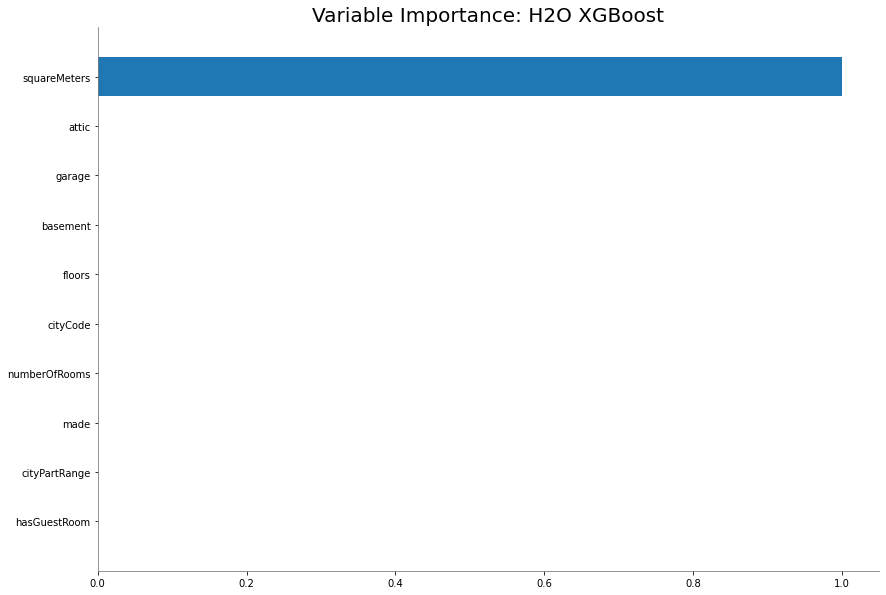

<Figure size 432x288 with 0 Axes>

In [21]:
#Plotting variable importance graph for xgboost
if best_model.algo in ['gbm','drf','xrt','xgboost']:
  best_model.varimp_plot()

I have plotted a few box plots to observe the relationship between the predictor variables such as hasPool, isNewBuilt, hasStorageRoom, hasStormProtector and hasYard and their impact of the target variable. Here, we can see that these predictors have very little effect on the results individually.

But these features may still be significant when they interact with each other. I have tested this in the later part of the notebook by computing their p-values.

In [22]:
df = pd.read_csv(url)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


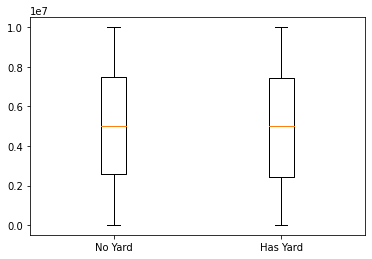

In [23]:
temp1 = df.loc[df['hasYard']==0]
temp2 = df.loc[df['hasYard']==1]
temparr = []
temparr.append(np.array(temp1['price']))
temparr.append(np.array(temp2['price']))
plt.boxplot(temparr, labels=['No Yard', 'Has Yard'])
plt.show()

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


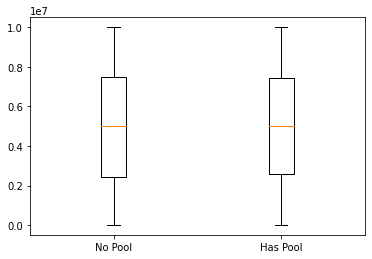

In [24]:
temp1 = df.loc[df['hasPool']==0]
temp2 = df.loc[df['hasPool']==1]
temparr = []
temparr.append(np.array(temp1['price']))
temparr.append(np.array(temp2['price']))
plt.boxplot(temparr, labels=['No Pool', 'Has Pool'])
plt.show()

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


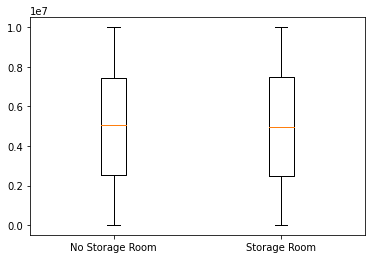

In [25]:
temp1 = df.loc[df['hasStorageRoom']==0]
temp2 = df.loc[df['hasStorageRoom']==1]
temparr = []
temparr.append(np.array(temp1['price']))
temparr.append(np.array(temp2['price']))
plt.boxplot(temparr, labels=['No Storage Room', 'Storage Room'])
plt.show()

# Regularization

Xgboost has important hyperparameters such as maximum tree depth, learning rate, L1 (alpha) and L2 (lambda) regularization rates and complexity control gamma.

Maximum tree depth: Specfies the tree depth. Higher depth may introduce overfitting and is usually used for larger data sets.

Learning rate: The rate by which to shrink the feature weights. Makes the model less conservative by shrinking the weights on each step.

Alpha: Used to apply L1 regularization (Lasso regression).

Lambda: Used to apply L2 regularization (Ridge regression).

Gamma: It is used to control the amount of regularization applied to your model (higher values of gamma signify higher regularization).

I have tested for regularization by considering only the significant features and adjusting values for alpha (L1 regularization), lambda (L2 regularization), learning rate and max depth. However, there is no improvement seen in the RSME values compared to earlier.

Hence, regularization does not appear to help in this case.

In [26]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [27]:
#Selecting features and target 
df = pd.read_csv(url)
X1 = df[['squareMeters', 'hasYard', 'hasPool', 'floors', 'cityPartRange', 'isNewBuilt', 'hasStormProtector']]
y1 = df[['price']]

#Split into training and test frame

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.8)

In [28]:
dmat_train = xgb.DMatrix(X_train, y_train)

In [29]:
dmatrix = xgb.DMatrix(data=X1, label=y1)

In [30]:
#Selecting the hyperparameters
params={ 'objective':'reg:linear',
         'max_depth': 6,
         'learning_rate': 0.5,
         'reg_alpha': 0.1,
         'reg_lambda': 0.01}

In [31]:
#Calculating RSME on training set based on above hyperparameters
booster = xgb.train(params=params, dtrain=dmatrix, evals=[(dmat_train, "train")])

[23:22:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:2.87546e+06
[1]	train-rmse:1.43831e+06
[2]	train-rmse:719588
[3]	train-rmse:360305
[4]	train-rmse:180873
[5]	train-rmse:91513.2
[6]	train-rmse:47527.1
[7]	train-rmse:26293.9
[8]	train-rmse:16765.2
[9]	train-rmse:13032.2


In [32]:
print("Train RMSE : ",booster.eval(dmat_train))

Train RMSE :  [0]	eval-rmse:13032.245117


# Analysing the dataset

We can see that all of the independent variables including categorial variables such as hasYard and hasPool belong to the integer data type and the dependent variable price has the data type float. There is no missing data for any of the columns in the Paris housing dataset.

In [33]:
df = pd.read_csv(url)

In [34]:
df.dtypes

squareMeters           int64
numberOfRooms          int64
hasYard                int64
hasPool                int64
floors                 int64
cityCode               int64
cityPartRange          int64
numPrevOwners          int64
made                   int64
isNewBuilt             int64
hasStormProtector      int64
basement               int64
attic                  int64
garage                 int64
hasStorageRoom         int64
hasGuestRoom           int64
price                float64
dtype: object

In [35]:
df.isnull().sum()

squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
price                0
dtype: int64

 I have used Variance Inflation Factor to observe the dependencies between the predictor variables and detect any multicollinearity between them. The value for VIF starts from 1 and can range to infinity. A lower value indicates low multicollinearity between variables.

From the calculation for VIF, we can see that the predictor variables are independent of other predictor variables for the Paris Housing dataset.

In [36]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

y, X = dmatrices('price ~ squareMeters + numberOfRooms + floors + cityCode + cityPartRange + numPrevOwners + made + basement + attic + garage + hasGuestRoom + hasPool + hasYard + hasStormProtector + hasStorageRoom + isNewBuilt', data=df, return_type='dataframe')

vifcalc = pd.DataFrame()
vifcalc['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vifcalc['variable'] = X.columns

In [37]:
vifcalc

VIF           variable
0   46469.639276          Intercept
1       1.001078       squareMeters
2       1.002577      numberOfRooms
3       1.001253             floors
4       1.000527           cityCode
5       1.001019      cityPartRange
6       1.002557      numPrevOwners
7       1.000634               made
8       1.001274           basement
9       1.001191              attic
10      1.002810             garage
11      1.002379       hasGuestRoom
12      1.001134            hasPool
13      1.000891            hasYard
14      1.000363  hasStormProtector
15      1.002822     hasStorageRoom
16      1.001623         isNewBuilt

Multicollinearity means that the predictor variables may be highly correlated with other predictors variables.

I have plotted a correlation matrix and its corresponding heatmap to test the multicollinearity between the predictor variables. Heatmap helps us to check if multicollinearity exists in a more intuitive manner. As we can see, there are no high correlations observed between the predictor variables.

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


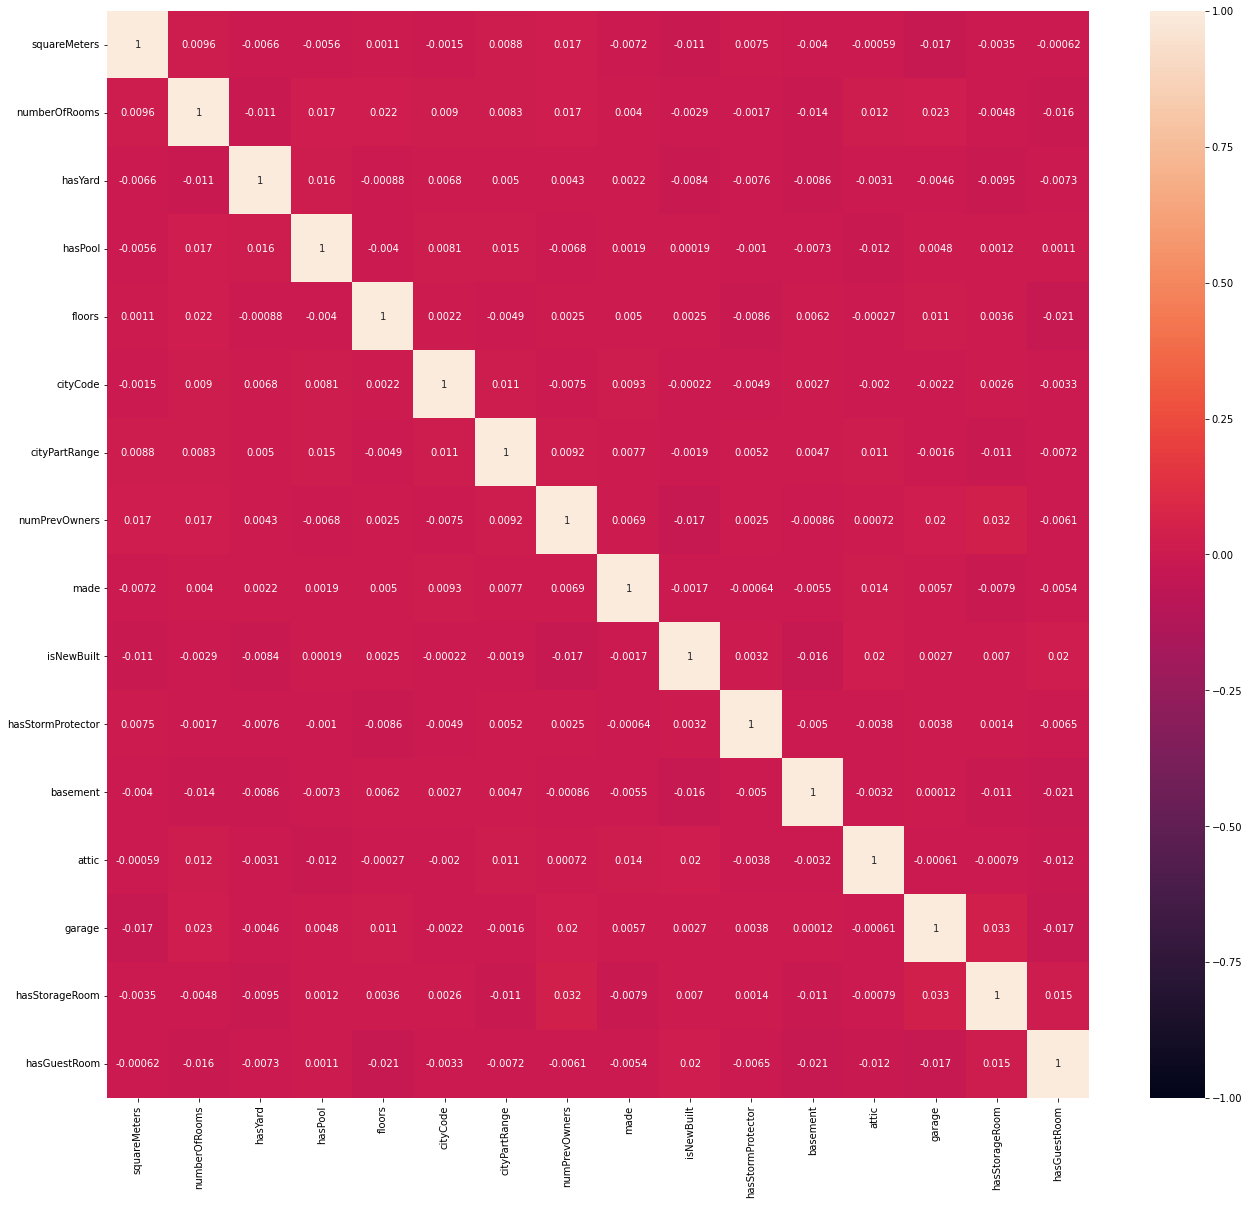

In [38]:
#Plotting heatmap using correlation matrix
df = df.drop('price',1)

corrMatrix = df.corr()

plt.figure(figsize=(22, 20))

heatmap = sns.heatmap(corrMatrix, vmin=-1, vmax=1, annot=True)

From the Q-Q plots and histograms plotted below, the numeric independent variables such as squareMeters, numberOfRooms,floors, garage, attic, cityCode follow uniform distribution. The predictors made, cityPartRange, numPrevOwners, hasGuestRoom have multimodal distribution.

The other independent variables such as garage, attic, hasPool, etc are categorial in nature with values 0 or 1.

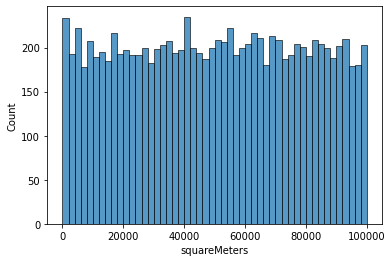

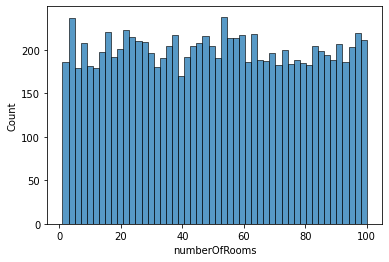

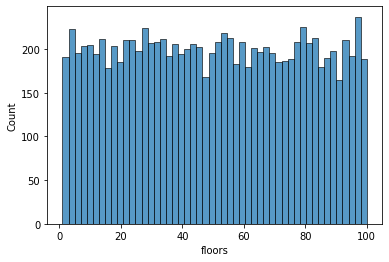

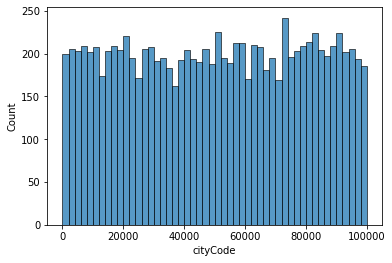

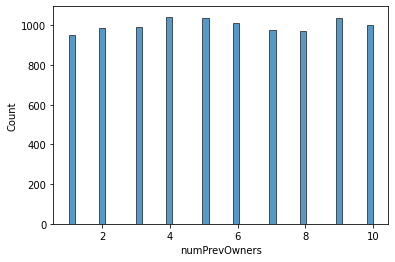

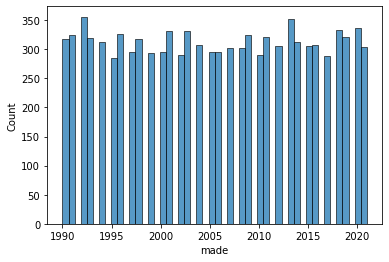

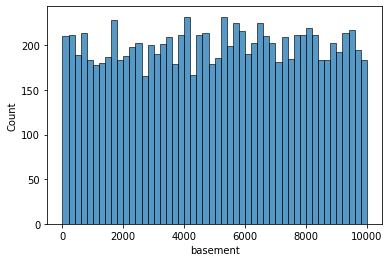

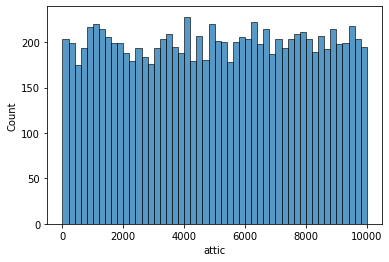

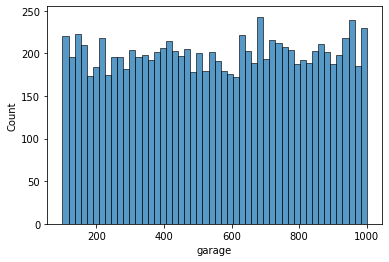

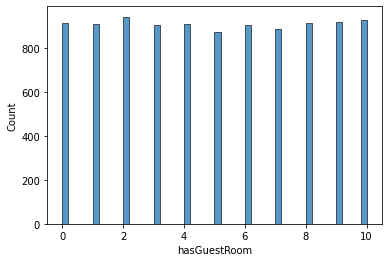

In [39]:
df = pd.read_csv(url)
df_hist = df.drop(['isNewBuilt','hasStorageRoom','cityPartRange','hasStormProtector','hasYard','hasPool','price'],axis=1)

for i, col in enumerate(df_hist.columns):
    plt.figure(i)
    sns.histplot(df[col],bins=50)

<Figure size 576x360 with 0 Axes>

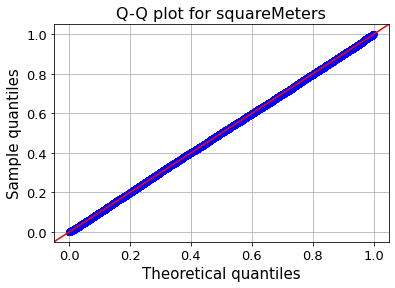

<Figure size 576x360 with 0 Axes>

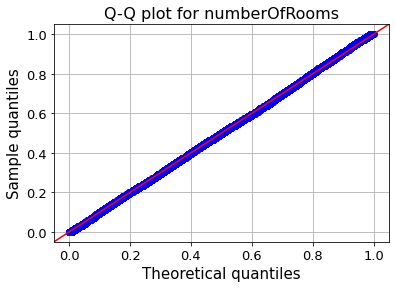

<Figure size 576x360 with 0 Axes>

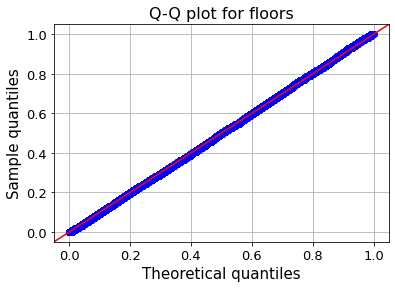

<Figure size 576x360 with 0 Axes>

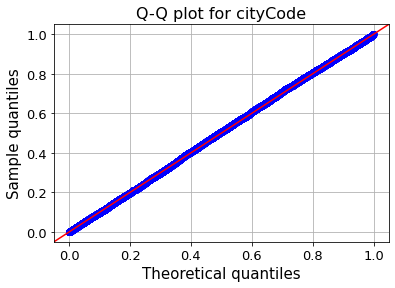

<Figure size 576x360 with 0 Axes>

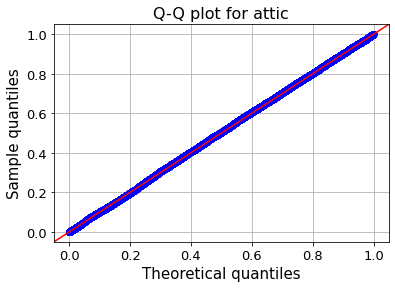

<Figure size 576x360 with 0 Axes>

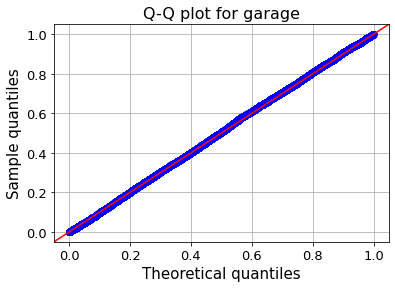

In [40]:
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats

data_norm= df[['squareMeters','numberOfRooms','floors','cityCode','attic','garage']]
for c in data_norm.columns[:]:
  plt.figure(figsize=(8,5))
  fig=qqplot(data_norm[c],dist='uniform',fit='True',line='45')
  plt.xticks(fontsize=13)
  plt.yticks(fontsize=13)
  plt.xlabel("Theoretical quantiles",fontsize=15)
  plt.ylabel("Sample quantiles",fontsize=15)
  plt.title("Q-Q plot for {}".format(c),fontsize=16)
  plt.grid(True)
  plt.show()

# Linear Regression

In [171]:
#Using OLS regression to calculate p-values
import statsmodels.formula.api as smf 
ols_result = smf.ols('price ~ squareMeters + numberOfRooms + floors + cityCode + cityPartRange + numPrevOwners + made + basement + attic + garage + hasGuestRoom + hasPool + hasYard + hasStormProtector + hasStorageRoom + isNewBuilt', data=df).fit()

In [172]:
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.436e+09
Date:                Sat, 07 May 2022   Prob (F-statistic):               0.00
Time:                        00:02:37   Log-Likelihood:                -89669.
No. Observations:               10000   AIC:                         1.794e+05
Df Residuals:                    9983   BIC:                         1.795e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          4926.7586   4092.409      1.204      0.229   -3095.188    1.29e+04
squareMeters        100.0000      0.001   1.51e+05      0.000      99.999     100.001
numberOfRooms         0.2518      0.660      0.382      0.703      -1.041       1.545
floors               54.5421      0.658     82.943      0.000      53.253      55.831
cityCode             -0.0008      0.001     -1.228      0.220      -0.002       0.000
cityPartRange        47.3685      6.614      7.162      0.000      34.404      60.333
numPrevOwners        -0.3957      6.654     -0.059      0.953     -13.440      12.648
made                 -2.3131      2.040     -1.134      0.257      -6.313       1.686
basement             -0.0021      0.007     -0.319      0.750      -0.015       0.011
attic                -0.0045      0.007     -0.687      0.492      -0.017       0.008
garage                0.1134      0.073      1.563      0.118      -0.029       0.256
hasGuestRoom         -5.6203      5.984     -0.939      0.348     -17.350       6.110
hasPool            2977.1378     37.991     78.365      0.000    2902.668    3051.608
hasYard            3012.2955     37.991     79.289      0.000    2937.825    3086.766
hasStormProtector   141.1961     37.975      3.718      0.000      66.757     215.636
hasStorageRoom       19.4856     38.023      0.512      0.608     -55.047      94.018
isNewBuilt          158.0415     37.999      4.159      0.000      83.555     232.528
==============================================================================
Omnibus:                       11.892   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               13.724
Skew:                           0.012   Prob(JB):                      0.00105
Kurtosis:                       3.180   Cond. No.                     1.65e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# XGBoost

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [42]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train_scaled, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

[23:23:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


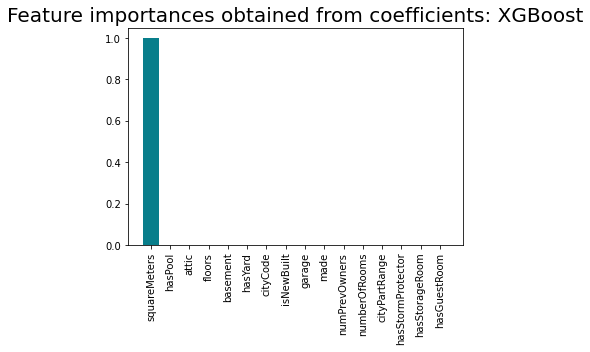

In [43]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients: XGBoost', size=20)
plt.xticks(rotation='vertical')
plt.show()

# Random Forest

In [44]:
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train_scaled, y_train)
importances1 = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importances_
})

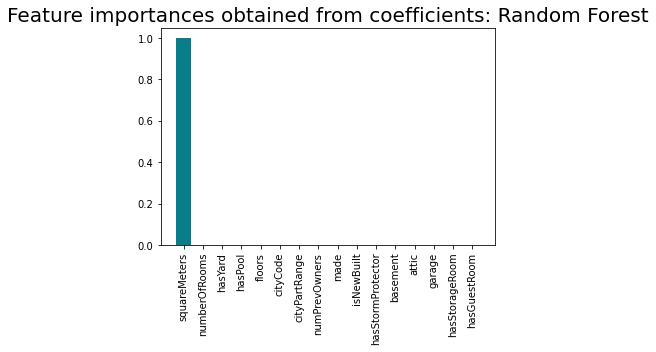

In [45]:
plt.bar(x=importances1['Attribute'], height=importances1['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients: Random Forest', size=20)
plt.xticks(rotation='vertical')
plt.show()

I have used least squares, xgboost regressor and random forest regressor to determine the useful independent variables. As we can see from the above graphs, in both xgboost and random forest there is strong relationship between the squareMeters and the target variable (price).

# Imputation

I have used 3 imputation techniques for recovering the missing data (1%, 5% and 10% of missing data): K Nearest Neighbours, Mean and Median. Out of these three methods, KNN seems to have the best performance whereas Mean and Median seem to be poor in recovering the values based on the % change from the original values.

### KNN Imputation

In [46]:
#KNN Imputation with 1%, 5% and 10% missing data
df = pd.read_csv(url)
def get_percent_missing(df):
    
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})
    return missing_value_df

In [47]:
df['squareMeters_1_percent'] = df[['squareMeters']]
df['squareMeters_5_percent'] = df[['squareMeters']]
df['squareMeters_10_percent'] = df[['squareMeters']]

In [48]:
print(get_percent_missing(df))

                                     column_name  percent_missing
squareMeters                        squareMeters              0.0
numberOfRooms                      numberOfRooms              0.0
hasYard                                  hasYard              0.0
hasPool                                  hasPool              0.0
floors                                    floors              0.0
cityCode                                cityCode              0.0
cityPartRange                      cityPartRange              0.0
numPrevOwners                      numPrevOwners              0.0
made                                        made              0.0
isNewBuilt                            isNewBuilt              0.0
hasStormProtector              hasStormProtector              0.0
basement                                basement              0.0
attic                                      attic              0.0
garage                                    garage              0.0
hasStorage

In [49]:
def create_missing(dataframe, percent, col):
    dataframe.loc[df.sample(frac = percent).index, col] = np.nan

In [50]:
create_missing(df, 0.01, 'squareMeters_1_percent')
create_missing(df, 0.05, 'squareMeters_5_percent')
create_missing(df, 0.1, 'squareMeters_10_percent')

In [51]:
print(get_percent_missing(df))

                                     column_name  percent_missing
squareMeters                        squareMeters              0.0
numberOfRooms                      numberOfRooms              0.0
hasYard                                  hasYard              0.0
hasPool                                  hasPool              0.0
floors                                    floors              0.0
cityCode                                cityCode              0.0
cityPartRange                      cityPartRange              0.0
numPrevOwners                      numPrevOwners              0.0
made                                        made              0.0
isNewBuilt                            isNewBuilt              0.0
hasStormProtector              hasStormProtector              0.0
basement                                basement              0.0
attic                                      attic              0.0
garage                                    garage              0.0
hasStorage

In [52]:
number_1_idx = list(np.where(df['squareMeters_1_percent'].isna())[0])
number_5_idx = list(np.where(df['squareMeters_5_percent'].isna())[0])
number_10_idx = list(np.where(df['squareMeters_10_percent'].isna())[0])

In [53]:
print(f"Length of number_1_idx is {len(number_1_idx)} and it contains {(len(number_1_idx)/len(df['squareMeters']))*100}% of total data in column | Total rows: {len(df['squareMeters'])}")
print(f"Length of number_5_idx is {len(number_1_idx)} and it contains {(len(number_5_idx)/len(df['squareMeters']))*100}% of total data in column | Total rows: {len(df['squareMeters'])}")
print(f"Length of number_10_idx is {len(number_10_idx)} and it contains {(len(number_10_idx)/len(df['squareMeters']))*100}% of total data in column | Total rows: {len(df['squareMeters'])}")

Length of number_1_idx is 100 and it contains 1.0% of total data in column | Total rows: 10000
Length of number_5_idx is 100 and it contains 5.0% of total data in column | Total rows: 10000
Length of number_10_idx is 1000 and it contains 10.0% of total data in column | Total rows: 10000


In [54]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

df_number1 = df[['price','squareMeters_1_percent']]
imputer = KNNImputer(n_neighbors=5)
imputed_number_df = pd.DataFrame(imputer.fit_transform(df_number1), columns = df_number1.columns)

In [55]:
imputed_number_df.sample(10)

price  squareMeters_1_percent
6495  5426769.1                 54245.0
6138  1169525.9                 11660.0
4201  1265496.3                 12555.0
3617  4387370.7                 43776.0
7565  8709056.5                 87047.0
5364  6375077.5                 63693.0
2434  2717313.0                 27119.0
3383  3405161.5                 33976.0
3645   693484.9                  6921.0
9331  2857049.8                 28472.0

In [56]:
print(get_percent_missing(imputed_number_df))

                                   column_name  percent_missing
price                                    price              0.0
squareMeters_1_percent  squareMeters_1_percent              0.0


In [57]:
imputed_number_df['original'] = df['squareMeters']

In [58]:
imputed_number_df['diff'] = imputed_number_df['original'] - imputed_number_df['squareMeters_1_percent']

In [59]:
print("Printing % change for the missing data (1% missing data)")

for i in number_1_idx:
  print(str(imputed_number_df['squareMeters_1_percent'][i])+", "+str(imputed_number_df['original'][i])+",% Change: "+str(abs(imputed_number_df['diff'][i])/imputed_number_df['original'][i]))

Printing % change for the missing data (1% missing data)
6033.6, 6071,% Change: 0.0061604348542249445
20632.0, 20624,% Change: 0.0003878975950349108
59040.0, 59073,% Change: 0.0005586308465796557
69404.4, 69443,% Change: 0.0005558515617125674
53354.0, 53304,% Change: 0.0009380159087498124
39763.2, 39734,% Change: 0.0007348869985402197
22300.0, 22348,% Change: 0.0021478432074458565
70550.4, 70494,% Change: 0.0008000680909012707
37465.6, 37494,% Change: 0.0007574545260575413
10333.2, 10320,% Change: 0.001279069767441931
34373.6, 34410,% Change: 0.0010578320255740033
68565.0, 68573,% Change: 0.0001166639931168244
19687.8, 19745,% Change: 0.002896935933147669
64720.0, 64720,% Change: 0.0
55680.4, 55620,% Change: 0.0010859403092413063
5414.8, 5431,% Change: 0.0029828760817528664
59790.4, 59850,% Change: 0.0009958228905597084
54730.6, 54789,% Change: 0.0010659073901695861
77424.2, 77472,% Change: 0.0006169971086328339
64243.2, 64265,% Change: 0.00033922041546725136
28361.0, 28347,% Change: 0

In [60]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

df_number2 = df[['price','squareMeters_5_percent']]
imputer = KNNImputer(n_neighbors=5)
imputed_number_df = pd.DataFrame(imputer.fit_transform(df_number2), columns = df_number2.columns)

In [61]:
imputed_number_df.sample(10)

price  squareMeters_5_percent
6351   327481.7                  3239.0
28    1189939.3                 11844.0
6481  5576689.9                 55668.0
3216   748575.3                  7418.8
2573  2285071.0                 22822.0
3991  6650604.5                 66442.0
1972  7920131.9                 79138.2
5976  9648728.5                 96364.0
4037  8870135.7                 88646.0
8617  1458693.1                 14447.0

In [62]:
imputed_number_df['original'] = df['squareMeters']

In [63]:
imputed_number_df['diff'] = imputed_number_df['original'] - imputed_number_df['squareMeters_5_percent']

In [64]:
print("Printing % change for the missing data (5% missing data)")

for i in number_5_idx:
    print(str(imputed_number_df['squareMeters_5_percent'][i])+", "+str(imputed_number_df['original'][i])+", % Change: "+str(abs(imputed_number_df['diff'][i])/imputed_number_df['original'][i]))

Printing % change for the missing data (5% missing data)
97567.0, 97550, % Change: 0.0001742696053305997
10500.2, 10500, % Change: 1.9047619047688344e-05
4164.6, 4187, % Change: 0.005349892524480448
47611.2, 47664, % Change: 0.0011077542799597792
62866.4, 62887, % Change: 0.0003275716761810636
14791.2, 14830, % Change: 0.0026163182737693374
38340.0, 38398, % Change: 0.0015104953382988698
63900.4, 63875, % Change: 0.00039765166340511085
17331.8, 17297, % Change: 0.002011909579695859
69699.6, 69638, % Change: 0.0008845745139149002
23926.6, 23898, % Change: 0.0011967528663485876
24456.2, 24393, % Change: 0.002590907227483324
78323.4, 78382, % Change: 0.0007476206271848871
70455.4, 70503, % Change: 0.0006751485752380157
42000.0, 41972, % Change: 0.00066711140760507
10713.0, 10714, % Change: 9.333582228859437e-05
14370.2, 14447, % Change: 0.005315982556932185
6574.4, 6617, % Change: 0.0064379628230316404
50106.8, 50066, % Change: 0.0008149242999241583
70529.0, 70576, % Change: 0.00066594876

In [65]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

df_number3 = df[['price','squareMeters_10_percent']]
imputer = KNNImputer(n_neighbors=5)
imputed_number_df = pd.DataFrame(imputer.fit_transform(df_number3), columns = df_number3.columns)

In [66]:
imputed_number_df.sample(10)

price  squareMeters_10_percent
3996   422514.7                   4167.0
8068  8675635.7                  86677.0
5264  7809037.7                  77989.0
3910  7591705.7                  75848.0
4225  6205630.3                  62028.0
3713  4092414.0                  40839.0
8692  5906126.1                  59016.0
9941  6407670.3                  63990.0
9087  5683041.8                  56726.0
1117  3475991.0                  34713.0

In [67]:
imputed_number_df['original'] = df['squareMeters']

In [68]:
imputed_number_df['diff'] = imputed_number_df['original'] - imputed_number_df['squareMeters_10_percent']

In [69]:
print("Printing % change for the missing data (10% missing data)")

for i in number_10_idx:
    print(str(imputed_number_df['squareMeters_10_percent'][i])+", "+str(imputed_number_df['original'][i])+",% Change: "+str(abs(imputed_number_df['diff'][i])/imputed_number_df['original'][i]))

Printing % change for the missing data (10% missing data)
80798.6, 80771,% Change: 0.00034170680070824705
51480.2, 51522,% Change: 0.0008113039090097999
23601.6, 23563,% Change: 0.0016381615244238231
11817.0, 11844,% Change: 0.0022796352583586625
85467.2, 85443,% Change: 0.0002832297555094869
26123.2, 26169,% Change: 0.001750162405900083
24194.0, 24239,% Change: 0.0018565122323528198
10477.8, 10500,% Change: 0.0021142857142857838
47010.0, 46988,% Change: 0.00046820464799523284
63073.6, 63053,% Change: 0.00032670927632307017
41986.2, 41998,% Change: 0.0002809657602743681
38376.2, 38430,% Change: 0.0013999479573250822
70769.0, 70751,% Change: 0.00025441336518211756
81922.8, 81870,% Change: 0.0006449248809087933
72119.2, 72098,% Change: 0.00029404421759268067
1421.0, 1450,% Change: 0.02
71407.0, 71397,% Change: 0.00014006190736305448
57155.6, 57160,% Change: 7.697690692794708e-05
36013.2, 36031,% Change: 0.0004940190391608035
22725.0, 22776,% Change: 0.002239199157007376
74373.0, 74325,% 

### Mean Imputation

In [70]:
df = pd.read_csv(url)

In [71]:
df['squareMeters_1_percent'] = df[['squareMeters']]
df['squareMeters_5_percent'] = df[['squareMeters']]
df['squareMeters_10_percent'] = df[['squareMeters']]

In [72]:
create_missing(df, 0.01, 'squareMeters_1_percent')
create_missing(df, 0.05, 'squareMeters_5_percent')
create_missing(df, 0.1, 'squareMeters_10_percent')

In [73]:
mean_imputed = df.fillna(df.mean())

In [74]:
mean_imputed.head()

squareMeters  numberOfRooms  hasYard  hasPool  floors  cityCode  \
0         75523              3        0        1      63      9373   
1         80771             39        1        1      98     39381   
2         55712             58        0        1      19     34457   
3         32316             47        0        0       6     27939   
4         70429             19        1        1      90     38045   

   cityPartRange  numPrevOwners  made  isNewBuilt  hasStormProtector  \
0              3              8  2005           0                  1   
1              8              6  2015           1                  0   
2              6              8  2021           0                  0   
3             10              4  2012           0                  1   
4              3              7  1990           1                  0   

   basement  attic  garage  hasStorageRoom  hasGuestRoom      price  \
0      4313   9005     956               0             7  7559081.5   
1      3653   2436     128               1             2  8085989.5   
2      2937   8852     135               1             9  5574642.1   
3       659   7141     359               0             3  3232561.2   
4      8435   2429     292               1             4  7055052.0   

   squareMeters_1_percent  squareMeters_5_percent  squareMeters_10_percent  
0                 75523.0                 75523.0             75523.000000  
1                 80771.0                 80771.0             80771.000000  
2                 55712.0                 55712.0             55712.000000  
3                 32316.0                 32316.0             50038.268444  
4                 70429.0                 70429.0             70429.000000

In [75]:
print("Printing % change for the missing data (1% missing data)")

for i in range(10000):
    if mean_imputed.squareMeters[i] - mean_imputed.squareMeters_1_percent[i] > 0:
      print(str(mean_imputed.squareMeters[i])+", "+str(mean_imputed.squareMeters_1_percent[i])+",% Change: "+str(abs(mean_imputed.squareMeters[i] - mean_imputed.squareMeters_1_percent[i])/mean_imputed.squareMeters[i]))

Printing % change for the missing data (1% missing data)
76635, 49888.36090909091,% Change: 0.3490133632271037
54133, 49888.36090909091,% Change: 0.07841130347309573
91757, 49888.36090909091,% Change: 0.45629912803283773
81619, 49888.36090909091,% Change: 0.3887653498684019
64654, 49888.36090909091,% Change: 0.2283793592184411
79629, 49888.36090909091,% Change: 0.3734900487373833
61480, 49888.36090909091,% Change: 0.18854325131602295
80323, 49888.36090909091,% Change: 0.37890316709920063
69265, 49888.36090909091,% Change: 0.2797464677818392
87561, 49888.36090909091,% Change: 0.4302445048698518
85926, 49888.36090909091,% Change: 0.4194031968310999
64108, 49888.36090909091,% Change: 0.22180756053704828
55518, 49888.36090909091,% Change: 0.10140205142312568
79182, 49888.36090909091,% Change: 0.3699532607273003
94109, 49888.36090909091,% Change: 0.46988746125141156
75853, 49888.36090909091,% Change: 0.3423020723097187
99840, 49888.36090909091,% Change: 0.5003168979458043
77018, 49888.36090

In [76]:
print("Printing % change for the missing data (5% missing data)")

for i in range(10000):
    if mean_imputed.squareMeters[i] - mean_imputed.squareMeters_5_percent[i] > 0:
      print(str(mean_imputed.squareMeters[i])+", "+str(mean_imputed.squareMeters_5_percent[i])+",% Change: "+str(abs(mean_imputed.squareMeters[i] - mean_imputed.squareMeters_5_percent[i])/mean_imputed.squareMeters[i]))

Printing % change for the missing data (5% missing data)
95121, 50121.69073684211,% Change: 0.4730743922284027
71397, 50121.69073684211,% Change: 0.2979860395136755
62887, 50121.69073684211,% Change: 0.20298804622828073
98969, 50121.69073684211,% Change: 0.49356171390190756
68416, 50121.69073684211,% Change: 0.26739811247599815
96687, 50121.69073684211,% Change: 0.4816087919074735
97008, 50121.69073684211,% Change: 0.4833241512365773
53339, 50121.69073684211,% Change: 0.06031813988184801
67020, 50121.69073684211,% Change: 0.25213830592596076
98266, 50121.69073684211,% Change: 0.48993862844888253
57897, 50121.69073684211,% Change: 0.13429554662863172
70942, 50121.69073684211,% Change: 0.29348353955566364
63719, 50121.69073684211,% Change: 0.2133948941941633
87668, 50121.69073684211,% Change: 0.42827838279826036
86042, 50121.69073684211,% Change: 0.41747413197226807
60263, 50121.69073684211,% Change: 0.16828417541705343
74938, 50121.69073684211,% Change: 0.3311578806901424
87362, 50121.6

In [77]:
print("Printing % change for the missing data (10% missing data)")

for i in range(10000):
    if mean_imputed.squareMeters[i] - mean_imputed.squareMeters_10_percent[i] > 0:
      print(str(mean_imputed.squareMeters[i])+", "+str(mean_imputed.squareMeters_10_percent[i])+",% Change: "+str(abs(mean_imputed.squareMeters[i] - mean_imputed.squareMeters_10_percent[i])/mean_imputed.squareMeters[i]))

Printing % change for the missing data (10% missing data)
70021, 50038.268444444446,% Change: 0.2853819790570765
54368, 50038.268444444446,% Change: 0.07963749918252565
93876, 50038.268444444446,% Change: 0.46697485571983843
66621, 50038.268444444446,% Change: 0.24891147769555477
72098, 50038.268444444446,% Change: 0.3059687030923958
57160, 50038.268444444446,% Change: 0.12459292434491873
72798, 50038.268444444446,% Change: 0.31264226428686986
64920, 50038.268444444446,% Change: 0.2292318477442322
87267, 50038.268444444446,% Change: 0.4266072118390177
73900, 50038.268444444446,% Change: 0.3228921726056232
93506, 50038.268444444446,% Change: 0.46486569370474146
63631, 50038.268444444446,% Change: 0.2136180722533915
77915, 50038.268444444446,% Change: 0.35778388699936536
94311, 50038.268444444446,% Change: 0.4694333805765558
67491, 50038.268444444446,% Change: 0.25859346513691533
70763, 50038.268444444446,% Change: 0.2928752533888551
80808, 50038.268444444446,% Change: 0.3807758087758087

### Median Imputation

In [78]:
df = pd.read_csv(url)

In [79]:
df['squareMeters_1_percent'] = df[['squareMeters']]
df['squareMeters_5_percent'] = df[['squareMeters']]
df['squareMeters_10_percent'] = df[['squareMeters']]

In [80]:
create_missing(df, 0.01, 'squareMeters_1_percent')
create_missing(df, 0.05, 'squareMeters_5_percent')
create_missing(df, 0.1, 'squareMeters_10_percent')

In [81]:
median_imputed = df.fillna(df.median())

In [82]:
median_imputed.head()

squareMeters  numberOfRooms  hasYard  hasPool  floors  cityCode  \
0         75523              3        0        1      63      9373   
1         80771             39        1        1      98     39381   
2         55712             58        0        1      19     34457   
3         32316             47        0        0       6     27939   
4         70429             19        1        1      90     38045   

   cityPartRange  numPrevOwners  made  isNewBuilt  hasStormProtector  \
0              3              8  2005           0                  1   
1              8              6  2015           1                  0   
2              6              8  2021           0                  0   
3             10              4  2012           0                  1   
4              3              7  1990           1                  0   

   basement  attic  garage  hasStorageRoom  hasGuestRoom      price  \
0      4313   9005     956               0             7  7559081.5   
1      3653   2436     128               1             2  8085989.5   
2      2937   8852     135               1             9  5574642.1   
3       659   7141     359               0             3  3232561.2   
4      8435   2429     292               1             4  7055052.0   

   squareMeters_1_percent  squareMeters_5_percent  squareMeters_10_percent  
0                 75523.0                 75523.0                  75523.0  
1                 80771.0                 80771.0                  80771.0  
2                 55712.0                 55712.0                  55712.0  
3                 32316.0                 32316.0                  32316.0  
4                 70429.0                 70429.0                  70429.0

In [83]:
print("Printing % change for the missing data (1% missing data)")

for i in range(10000):
    if median_imputed.squareMeters[i] - median_imputed.squareMeters_1_percent[i] > 0:
      print(str(median_imputed.squareMeters[i])+", "+str(median_imputed.squareMeters_1_percent[i])+",% Change: "+str(abs(median_imputed.squareMeters[i] - median_imputed.squareMeters_1_percent[i])/median_imputed.squareMeters[i]))

Printing % change for the missing data (1% missing data)
66683, 50111.5,% Change: 0.24851161465440966
57915, 50111.5,% Change: 0.13474056807390142
98543, 50111.5,% Change: 0.49147580244157374
80254, 50111.5,% Change: 0.3755887557006504
94638, 50111.5,% Change: 0.47049282529216596
50251, 50111.5,% Change: 0.0027760641579272056
79837, 50111.5,% Change: 0.37232736701028346
53662, 50111.5,% Change: 0.06616413849651523
59144, 50111.5,% Change: 0.15272047883132694
54993, 50111.5,% Change: 0.08876584292546325
75853, 50111.5,% Change: 0.3393603417135776
59752, 50111.5,% Change: 0.1613418797697148
54077, 50111.5,% Change: 0.07333062115132126
66442, 50111.5,% Change: 0.2457857981397309
58617, 50111.5,% Change: 0.145102956480202
78995, 50111.5,% Change: 0.36563706563706566
76671, 50111.5,% Change: 0.3464086812484512
68270, 50111.5,% Change: 0.26598066500659145
66180, 50111.5,% Change: 0.2427999395587791
98433, 50111.5,% Change: 0.4909075208517469
94947, 50111.5,% Change: 0.47221607844376334
57676

In [84]:
print("Printing % change for the missing data (5% missing data)")

for i in range(10000):
    if median_imputed.squareMeters[i] - median_imputed.squareMeters_5_percent[i] > 0:
      print(str(median_imputed.squareMeters[i])+", "+str(median_imputed.squareMeters_5_percent[i])+",% Change: "+str(abs(median_imputed.squareMeters[i] - median_imputed.squareMeters_5_percent[i])/median_imputed.squareMeters[i]))

Printing % change for the missing data (5% missing data)
82141, 49939.5,% Change: 0.3920271240915012
72798, 49939.5,% Change: 0.31399901096183963
99177, 49939.5,% Change: 0.4964608729846638
95441, 49939.5,% Change: 0.47675003405245125
56467, 49939.5,% Change: 0.11559849115412542
56480, 49939.5,% Change: 0.11580205382436261
67020, 49939.5,% Change: 0.25485675917636524
71989, 49939.5,% Change: 0.3062898498381697
51589, 49939.5,% Change: 0.03197387039872841
65479, 49939.5,% Change: 0.23732036225354694
88102, 49939.5,% Change: 0.4331626977821162
98266, 49939.5,% Change: 0.4917926851606863
56181, 49939.5,% Change: 0.1110962781011374
50638, 49939.5,% Change: 0.013793988704135235
51757, 49939.5,% Change: 0.03511602295341693
79337, 49939.5,% Change: 0.37053959690938654
67735, 49939.5,% Change: 0.2627223739573337
66940, 49939.5,% Change: 0.2539662384224679
77261, 49939.5,% Change: 0.3536260208902292
97544, 49939.5,% Change: 0.48803104240137785
95568, 49939.5,% Change: 0.47744537920642893
82468,

In [85]:
print("Printing % change for the missing data (10% missing data)")

for i in range(10000):
    if median_imputed.squareMeters[i] - median_imputed.squareMeters_10_percent[i] > 0:
      print(str(median_imputed.squareMeters[i])+", "+str(median_imputed.squareMeters_10_percent[i])+",% Change: "+str(abs(median_imputed.squareMeters[i] - median_imputed.squareMeters_10_percent[i])/median_imputed.squareMeters[i]))

Printing % change for the missing data (10% missing data)
99371, 49947.5,% Change: 0.4973634158859225
85443, 49947.5,% Change: 0.4154289994499257
54318, 49947.5,% Change: 0.08046135719282742
70021, 49947.5,% Change: 0.28667828222961683
66621, 49947.5,% Change: 0.2502739376472884
81870, 49947.5,% Change: 0.38991694149261025
73062, 49947.5,% Change: 0.31636828994552574
74325, 49947.5,% Change: 0.32798520013454424
59517, 49947.5,% Change: 0.16078599391770418
98969, 49947.5,% Change: 0.4953217674221221
72495, 49947.5,% Change: 0.31102144975515555
98121, 49947.5,% Change: 0.4909601410503358
98868, 49947.5,% Change: 0.49480620625480437
68416, 49947.5,% Change: 0.2699441651075772
87291, 49947.5,% Change: 0.4278046992244332
94471, 49947.5,% Change: 0.47129277767780586
56467, 49947.5,% Change: 0.11545681548515062
58263, 49947.5,% Change: 0.1427235123491753
62711, 49947.5,% Change: 0.20352888647924605
79344, 49947.5,% Change: 0.37049430328695304
51589, 49947.5,% Change: 0.03181879858109287
78183

# Outlier Analysis

I have run the XGBoost regressor which was the best model selected by AutoML by keeping and removing the outliers. We can see that there is improvement in the RSME value by removing the outliers.

In [86]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X2 = df.drop(['price','squareMeters_1_percent','squareMeters_5_percent','squareMeters_10_percent'],axis=1)
y2 = df[['price']]

#Split into training and test frame

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X2, y2, test_size=0.8)

#Split into training and test frame

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X2, y2, test_size=0.8)

In [87]:
dmat_train_1 = xgb.DMatrix(X_train_1, y_train_1)

In [88]:
dmatrix_1 = xgb.DMatrix(data=X2, label=y2)

In [89]:
params={ 'objective':'reg:linear',
         'max_depth': 6,
         'learning_rate': 0.5,
         'reg_alpha': 0.1,
         'reg_lambda': 0.01}

In [90]:
booster = xgb.train(params=params, dtrain=dmatrix_1, evals=[(dmat_train_1, "train")])

[23:23:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:2.84991e+06
[1]	train-rmse:1.42531e+06
[2]	train-rmse:712938
[3]	train-rmse:356869
[4]	train-rmse:179176
[5]	train-rmse:90901.8
[6]	train-rmse:47204
[7]	train-rmse:26448.4
[8]	train-rmse:17200.1
[9]	train-rmse:13551.2


In [91]:
print("Train RMSE : ",booster.eval(dmat_train_1))

Train RMSE :  [0]	eval-rmse:13551.179688


In [92]:
upper_limit = df['squareMeters'].quantile(0.95)
lower_limit = df['squareMeters'].quantile(0.05)
print('Upper Limit - ',upper_limit)
print('Lower Limit - ',lower_limit)

Upper Limit -  94695.34999999999
Lower Limit -  4779.85


In [93]:
new_df = df[(df['squareMeters'] <= 94695.34999999999) & (df['squareMeters'] >= 4779.85)]
print('Data before outliers - ', df.shape)
print('Data after outliers - ' , new_df.shape)

Data before outliers -  (10000, 20)
Data after outliers -  (9000, 20)


In [94]:
new_df.head()

squareMeters  numberOfRooms  hasYard  hasPool  floors  cityCode  \
0         75523              3        0        1      63      9373   
1         80771             39        1        1      98     39381   
2         55712             58        0        1      19     34457   
3         32316             47        0        0       6     27939   
4         70429             19        1        1      90     38045   

   cityPartRange  numPrevOwners  made  isNewBuilt  hasStormProtector  \
0              3              8  2005           0                  1   
1              8              6  2015           1                  0   
2              6              8  2021           0                  0   
3             10              4  2012           0                  1   
4              3              7  1990           1                  0   

   basement  attic  garage  hasStorageRoom  hasGuestRoom      price  \
0      4313   9005     956               0             7  7559081.5   
1      3653   2436     128               1             2  8085989.5   
2      2937   8852     135               1             9  5574642.1   
3       659   7141     359               0             3  3232561.2   
4      8435   2429     292               1             4  7055052.0   

   squareMeters_1_percent  squareMeters_5_percent  squareMeters_10_percent  
0                 75523.0                 75523.0                  75523.0  
1                 80771.0                 80771.0                  80771.0  
2                 55712.0                 55712.0                  55712.0  
3                 32316.0                 32316.0                  32316.0  
4                 70429.0                 70429.0                  70429.0

In [95]:
X1 = new_df.drop(['price','squareMeters_1_percent','squareMeters_5_percent','squareMeters_10_percent'],axis=1)
y1 = new_df[['price']]

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.8)

In [97]:
dmat_train = xgb.DMatrix(X_train, y_train)

In [98]:
dmatrix = xgb.DMatrix(data=X1, label=y1)

In [99]:
booster = xgb.train(params=params, dtrain=dmatrix, evals=[(dmat_train, "train")])

[23:23:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:2.82742e+06
[1]	train-rmse:1.41384e+06
[2]	train-rmse:707050
[3]	train-rmse:353777
[4]	train-rmse:177388
[5]	train-rmse:89605.5
[6]	train-rmse:46064.9
[7]	train-rmse:25302.8
[8]	train-rmse:15907.5
[9]	train-rmse:12417.9


In [100]:
print("Train RMSE : ",booster.eval(dmat_train))

Train RMSE :  [0]	eval-rmse:12417.871094


# Model Interpretability

# Linear Regression

In [101]:
from pandas.core.frame import DataFrame
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

df = pd.read_csv(url)
X = df.drop('price',axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [102]:
categorical_features = ['hasYard','hasPool','isNewBuilt','hasStormProtector','hasStorageRoom']
numerical_features = [c for c in X_train.columns if c not in categorical_features]

cat = [([c], [OrdinalEncoder()]) for c in categorical_features]
num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
mapper = DataFrameMapper(num + cat, df_out=True)

preprocessed_X_train = mapper.fit_transform(X_train)
preprocessed_X_train = sm.add_constant(preprocessed_X_train)

ols_reg = sm.OLS(y_train, preprocessed_X_train).fit()

In [103]:
def evaluate(X, y, mapper=None, reg=None, transform=False):
    if transform:
        X = mapper.transform(X)
        X = sm.add_constant(X, has_constant='add') 
    y_pred = ols_reg.predict(X)
    return mean_absolute_error(y, y_pred)

In [104]:
train_mae = evaluate(X_train, y_train, mapper, ols_reg, True)
test_mae = evaluate(X_test, y_test, mapper, ols_reg, True)
print(f"train MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)} ")

train MAE = 1475.227, test MAE = 1489.961 


In [105]:
#Printing summary results for Linear model
ols_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.152e+09
Date:                Fri, 06 May 2022   Prob (F-statistic):               0.00
Time:                        23:23:50   Log-Likelihood:                -71715.
No. Observations:                8000   AIC:                         1.435e+05
Df Residuals:                    7983   BIC:                         1.436e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              4.996e+06     52.206   9.57e+04      0.000       5e+06       5e+06
squareMeters       2.875e+06     21.188   1.36e+05      0.000    2.88e+06    2.88e+06
numberOfRooms        24.8792     21.203      1.173      0.241     -16.685      66.443
floors             1568.0897     21.195     73.985      0.000    1526.542    1609.637
cityCode            -17.0213     21.187     -0.803      0.422     -58.554      24.511
cityPartRange       140.8694     21.189      6.648      0.000      99.334     182.405
numPrevOwners         1.4552     21.210      0.069      0.945     -40.121      43.031
made                -13.0905     21.182     -0.618      0.537     -54.612      28.431
basement            -29.5896     21.190     -1.396      0.163     -71.128      11.949
attic               -16.3967     21.193     -0.774      0.439     -57.940      25.146
garage               28.6137     21.206      1.349      0.177     -12.956      70.184
hasGuestRoom         -6.1672     21.198     -0.291      0.771     -47.721      35.386
hasYard            3028.6368     42.381     71.462      0.000    2945.559    3111.715
hasPool            3012.5679     42.379     71.086      0.000    2929.494    3095.642
isNewBuilt          153.4302     42.412      3.618      0.000      70.291     236.569
hasStormProtector   141.1403     42.364      3.332      0.001      58.095     224.185
hasStorageRoom       11.7071     42.433      0.276      0.783     -71.473      94.887
==============================================================================
Omnibus:                        9.553   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               10.968
Skew:                           0.010   Prob(JB):                      0.00415
Kurtosis:                       3.180   Cond. No.                         4.83
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can observe from the t-score and the p-value that squareMeters has the highest significance of all of the predictor variables. Other predictor variables such as floors and cityPartRange are also significant.

We can see from the p-values below that the predictors hasPool, hasYard, hasStormProtector and isNewBuilt are also significant.

# Decision Tree

In [106]:
#Train test split and training the model using decision tree algorithm
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv(url)
X = df.drop('price',axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
regressor = DecisionTreeRegressor(max_depth=3, random_state=30)
regressor.fit(X_train, y_train)
y_pred=regressor.predict(X_test)
r2_score(y_pred, y_test)

0.9842086627893194

[Text(0.5, 0.875, 'X[0] <= 49650.5\nsquared_error = 8281213225420.414\nsamples = 9000\nvalue = 4999562.762'),
 Text(0.25, 0.625, 'X[0] <= 24714.5\nsquared_error = 2077906152749.478\nsamples = 4459\nvalue = 2490236.443'),
 Text(0.125, 0.375, 'X[0] <= 12197.0\nsquared_error = 520464589874.671\nsamples = 2204\nvalue = 1224087.328'),
 Text(0.0625, 0.125, 'squared_error = 126727038518.883\nsamples = 1104\nvalue = 597404.26'),
 Text(0.1875, 0.125, 'squared_error = 125881037619.646\nsamples = 1100\nvalue = 1853049.245'),
 Text(0.375, 0.375, 'X[0] <= 37263.5\nsquared_error = 501808185497.666\nsamples = 2255\nvalue = 3727749.812'),
 Text(0.3125, 0.125, 'squared_error = 131322475247.248\nsamples = 1133\nvalue = 3119381.435'),
 Text(0.4375, 0.125, 'squared_error = 124780720121.965\nsamples = 1122\nvalue = 4342082.585'),
 Text(0.75, 0.625, 'X[0] <= 74799.0\nsquared_error = 2118125169400.578\nsamples = 4541\nvalue = 7463576.429'),
 Text(0.625, 0.375, 'X[0] <= 62127.0\nsquared_error = 527376594286.6

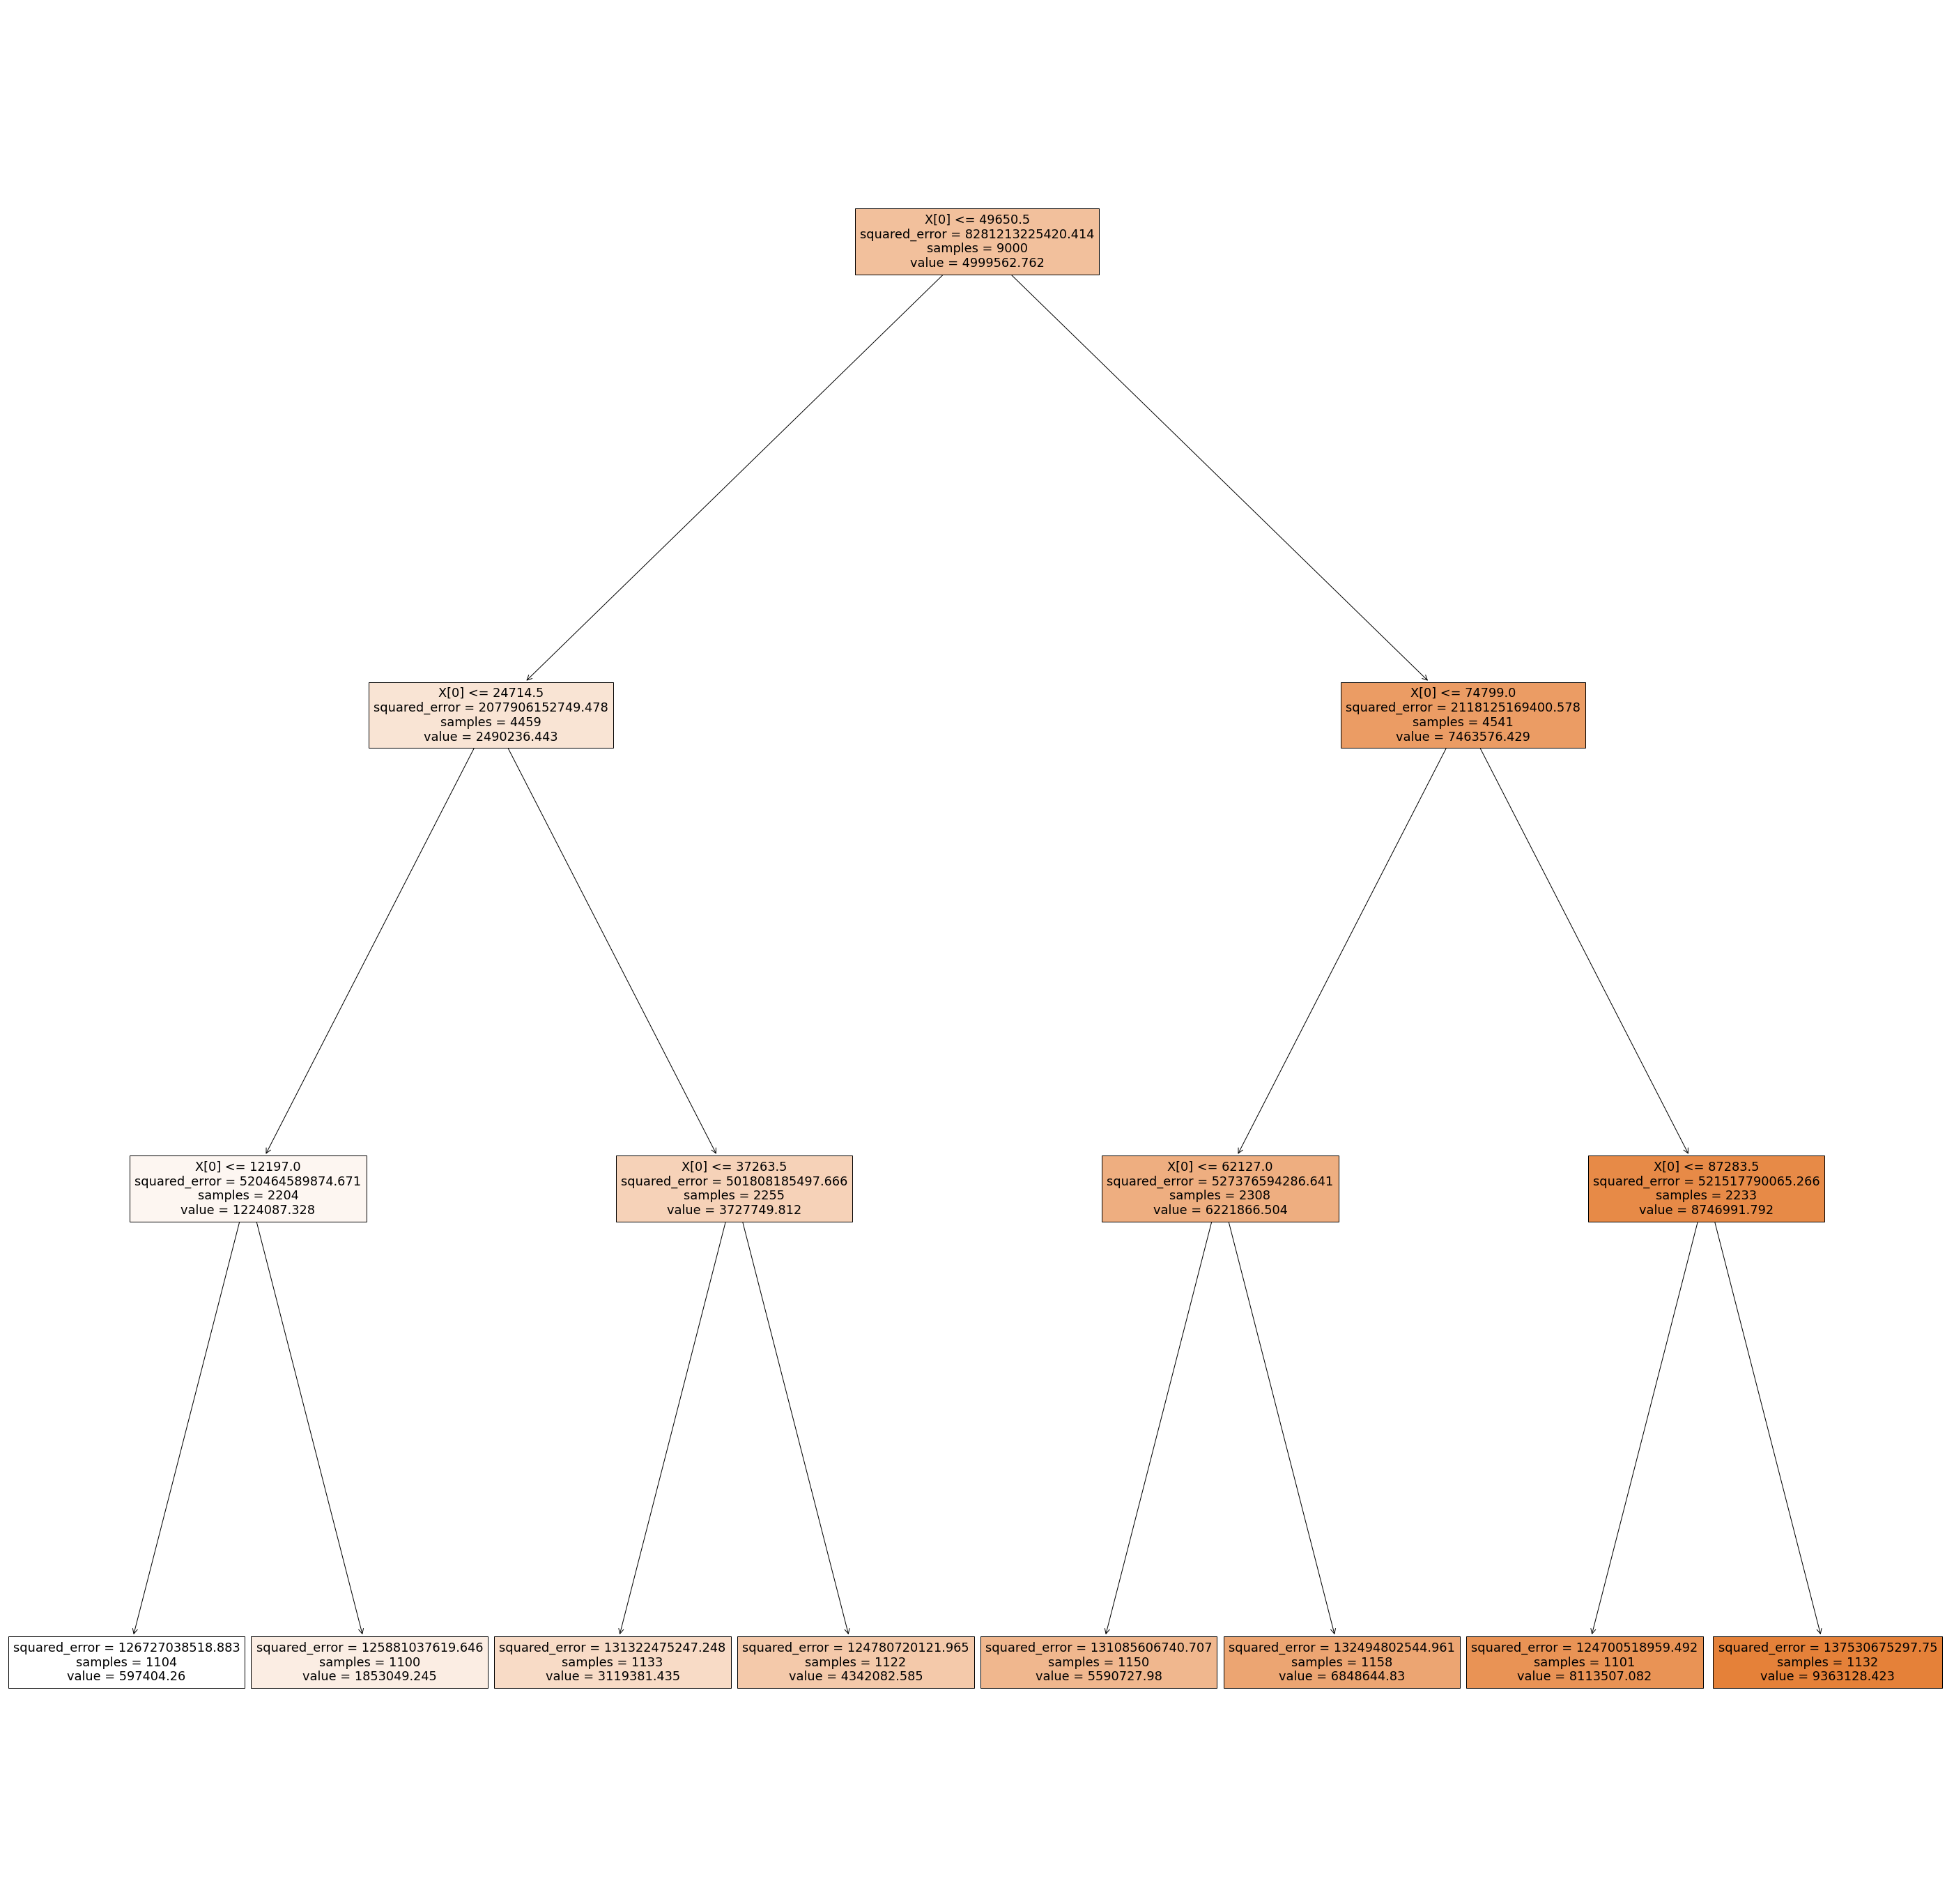

In [107]:
#Plotting decision tree
plt.figure(figsize=(50,50))
plot_tree(regressor, filled=True)

From the decision tree, we can see that squareMeters is used as the tree splitting criteria at all levels. Hence, we can see from the above tree that if the squareMeters area of the house is low then the predicted price of the house will be low and higher price for bigger houses with larger area.

In [108]:
# Setting a minimum memory size and a run time in seconds
min_mem_size=6 
run_time=300

In [109]:
# Use 50% of availible resources
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

3


In [110]:
# 65535 Highest port no
# Start the H2O server on a random port
port_no=random.randint(5555,55555)


try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:34199 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.15" 2022-04-19; OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1); OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpae0nb9nw
  JVM stdout: /tmp/tmpae0nb9nw/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpae0nb9nw/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:34199
Connecting to H2O server at http://127.0.0.1:34199 ... successful.


--------------------------  ----------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.36.1.1
H2O_cluster_version_age:    23 days
H2O_cluster_name:           H2O_from_python_unknownUser_kyp68h
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.172 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:34199
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.7.13 final
--------------------------  ----------------------------------

In [111]:
#Creating h2o dataframe
data = h2o.import_file(path = url)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [112]:
pct_rows=0.80
data_train, data_test = data.split_frame([pct_rows])

In [113]:
print(data_train.shape)
print(data_test.shape)

(8036, 17)
(1964, 17)


In [114]:
X=data.columns

In [115]:
#Setting the features and target variable
y ='price'
X.remove(y)

In [116]:
#AutoML setup and excluding Stacked Ensemble models
aml = H2OAutoML(max_runtime_secs=run_time, seed=1, exclude_algos= ["StackedEnsemble"])

In [117]:
aml.train(x=X,y=y,training_frame=data_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_1_20220506_232415_model_3


Model Summary: 


number_of_trees
0               46.0



ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 57939803.91215305
RMSE: 7611.820013121241
MAE: 5866.090304202378
RMSLE: 0.01139936082313772
Mean Residual Deviance: 57939803.91215305

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 108938869.65522636
RMSE: 10437.37848577057
MAE: 8097.306047469006
RMSLE: 0.017729016223450203
Mean Residual Deviance: 108938869.65522636

Cross-Validation Metrics Summary: 


mean            sd    cv_1_valid  \
0                     mae  8.097292e+03  1.684198e+02  8.210460e+03   
1  mean_residual_deviance  1.089382e+08  4.181680e+06  1.142519e+08   
2                     mse  1.089382e+08  4.181680e+06  1.142519e+08   
3                      r2  9.999870e-01  6.362290e-07  9.999861e-01   
4       residual_deviance  1.089382e+08  4.181680e+06  1.142519e+08   
5                    rmse  1.043581e+04  2.002931e+02  1.068887e+04   
6                   rmsle  1.704824e-02  5.441314e-03  1.505949e-02   

     cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid  
0  8.019917e+03  7.979748e+03  7.941306e+03  8.335029e+03  
1  1.040497e+08  1.093180e+08  1.055909e+08  1.114807e+08  
2  1.040497e+08  1.093180e+08  1.055909e+08  1.114807e+08  
3  9.999876e-01  9.999871e-01  9.999874e-01  9.999865e-01  
4  1.040497e+08  1.093180e+08  1.055909e+08  1.114807e+08  
5  1.020047e+04  1.045552e+04  1.027574e+04  1.055844e+04  
6  2.670150e-02  1.527192e-02  1.347149e-02  1.473681e-02


Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2022-05-06 23:28:41  31.795 sec              0.0   5.771732e+06   
1     2022-05-06 23:28:41  31.876 sec              5.0   9.714147e+05   
2     2022-05-06 23:28:41  31.938 sec             10.0   1.641257e+05   
3     2022-05-06 23:28:41  32.007 sec             15.0   2.989590e+04   
4     2022-05-06 23:28:41  32.085 sec             20.0   1.106165e+04   
5     2022-05-06 23:28:41  32.175 sec             25.0   9.288505e+03   
6     2022-05-06 23:28:41  32.279 sec             30.0   8.741336e+03   
7     2022-05-06 23:28:41  32.393 sec             35.0   8.454753e+03   
8     2022-05-06 23:28:41  32.514 sec             40.0   7.921610e+03   
9     2022-05-06 23:28:42  32.648 sec             45.0   7.633465e+03   
10    2022-05-06 23:28:42  32.707 sec             46.0   7.611820e+03   

    training_mae  training_deviance  
0   4.996062e+06       3.331289e+13  
1   8.406450e+05       9.436465e+11  
2   1.415718e+05       2.693725e+10  
3   2.454969e+04       8.937651e+08  
4   8.490638e+03       1.223601e+08  
5   7.104888e+03       8.627633e+07  
6   6.706739e+03       7.641095e+07  
7   6.476792e+03       7.148285e+07  
8   6.108264e+03       6.275190e+07  
9   5.886091e+03       5.826978e+07  
10  5.866090e+03       5.793980e+07


Variable Importances: 


variable  relative_importance  scaled_importance    percentage
0        squareMeters         1.314222e+17       1.000000e+00  9.999980e-01
1              floors         4.000913e+10       3.044320e-07  3.044314e-07
2               attic         3.535326e+10       2.690052e-07  2.690047e-07
3            cityCode         3.080157e+10       2.343711e-07  2.343706e-07
4            basement         2.928091e+10       2.228003e-07  2.227999e-07
5       numberOfRooms         2.273363e+10       1.729816e-07  1.729813e-07
6              garage         2.148017e+10       1.634440e-07  1.634436e-07
7                made         1.992648e+10       1.516218e-07  1.516215e-07
8        hasGuestRoom         1.188114e+10       9.040436e-08  9.040418e-08
9             hasPool         1.142230e+10       8.691300e-08  8.691283e-08
10            hasYard         1.076923e+10       8.194377e-08  8.194361e-08
11      numPrevOwners         9.450624e+09       7.191040e-08  7.191026e-08
12      cityPartRange         8.340724e+09       6.346510e-08  6.346497e-08
13         isNewBuilt         2.841065e+09       2.161785e-08  2.161780e-08
14  hasStormProtector         2.640316e+09       2.009033e-08  2.009029e-08
15     hasStorageRoom         8.657029e+08       6.587188e-09  6.587175e-09

In [118]:
print(aml.leaderboard)

model_id rmse mse mae rmsle mean_residual_deviance 
 
 
 XGBoost_grid_1_AutoML_1_20220506_232415_model_3 10437.4 1.08939e+08 8097.31 0.017729 1.08939e+08 
 DeepLearning_1_AutoML_1_20220506_232415 43562.4 1.89768e+09 34860.8 nan 1.89768e+09 
 GBM_5_AutoML_1_20220506_232415 55852.8 3.11954e+09 37360.1 nan 3.11954e+09 
 XGBoost_2_AutoML_1_20220506_232415 58870.9 3.46578e+09 35117.5 nan 3.46578e+09 
 GBM_1_AutoML_1_20220506_232415 60721.1 3.68705e+09 47734.3 nan 3.68705e+09 
 XGBoost_grid_1_AutoML_1_20220506_232415_model_2 68678.3 4.7167e+09 43845.3 nan 4.7167e+09 
 GBM_grid_1_AutoML_1_20220506_232415_model_2 71547.1 5.11899e+09 52694.9 nan 5.11899e+09 
 GBM_2_AutoML_1_20220506_232415 87696.6 7.6907e+09 64878.5 nan 7.6907e+09 
 XGBoost_3_AutoML_1_20220506_232415 95637.2 9.14647e+09 54380.9 nan 9.14647e+09 
 GBM_3_AutoML_1_20220506_232415 138205 1.91007e+10 101889 nan 1.91007e+10

In [119]:
model_index=0
glm_index=0
glm_model=''
aml_leaderboard_df=aml.leaderboard.as_data_frame()
models_dict={}
for m in aml_leaderboard_df['model_id']:
  models_dict[m]=model_index
  if 'StackedEnsemble' not in m:
    break 
  model_index=model_index+1  

for m in aml_leaderboard_df['model_id']:
  if 'GLM' in m:
    models_dict[m]=glm_index
    break  
  glm_index=glm_index+1     
models_dict

{'GLM_1_AutoML_1_20220506_232415': 17,
 'XGBoost_grid_1_AutoML_1_20220506_232415_model_3': 0}

In [120]:
best_model = h2o.get_model(aml.leaderboard[model_index,'model_id'])
best_model.algo

'xgboost'

In [121]:
bm = aml.get_best_model()

In [122]:
xgbparams = bm.params

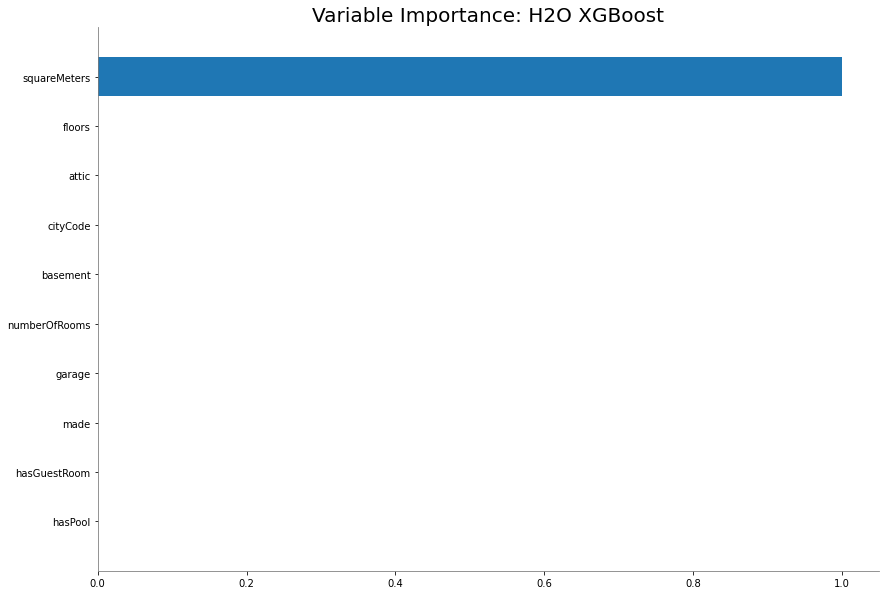

<Figure size 432x288 with 0 Axes>

In [123]:
best_model.varimp_plot()

We can see from the variable importance plot, that there is strong linear relationship between the squareMeters and the target variable (price). Other variables have very small impact on the target variable.

In [124]:
from sklearn.ensemble import RandomForestRegressor
from treeinterpreter import treeinterpreter as ti

df = pd.read_csv(url)
X = df.drop('price',axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
catagorical_features = ['hasYard','hasPool','isNewBuilt','hasStormProtector','hasStorageRoom']
numerical_features = [c for c in X_train.columns if c not in catagorical_features]
cat = [([c], [OrdinalEncoder()]) for c in catagorical_features]
num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
mapper = DataFrameMapper(num + cat, df_out=True)
reg = RandomForestRegressor()
pipeline = Pipeline([
    ('preprocess', mapper),
    ('reg', reg)
])
p = pipeline.fit(X_train, y_train)

In [125]:
explainer = shap.Explainer(pipeline.predict, X_train)
shap_values = explainer(X_test)

Permutation explainer: 1001it [17:35,  1.06s/it]


In [126]:
def partial_dependence_plot(feature, idx=None):
    if idx is None: # visualize all samples
        shap.plots.partial_dependence(
            feature,
            pipeline.predict,
            X_train, 
            ice=False,
            model_expected_value=True, 
            feature_expected_value=True)
    else: # visualize sample idx
        shap.partial_dependence_plot(
            feature, 
            pipeline.predict,
            X_train, 
            ice=False,
            model_expected_value=True, 
            feature_expected_value=True,
            shap_values=shap_values[idx:idx+1,:])

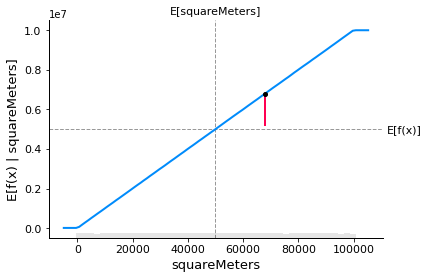

In [127]:
partial_dependence_plot('squareMeters', 0)

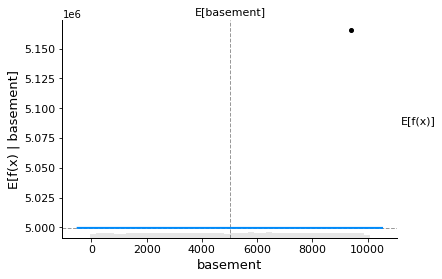

In [128]:
partial_dependence_plot('basement', 0)

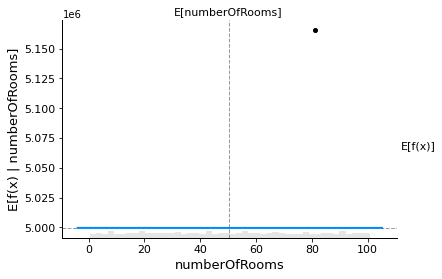

In [129]:
partial_dependence_plot('numberOfRooms', 0)

# Feature Importance with SHAP and LIME Analysis


In [130]:
def sample_feature_importance(idx, type='condensed'):
    if type == 'condensed':
        return shap.plots.force(shap_values[idx])
    elif type == 'waterfall':
        return shap.plots.waterfall(shap_values[idx])
    else:
        return "Return valid visual ('condensed', 'waterfall')"

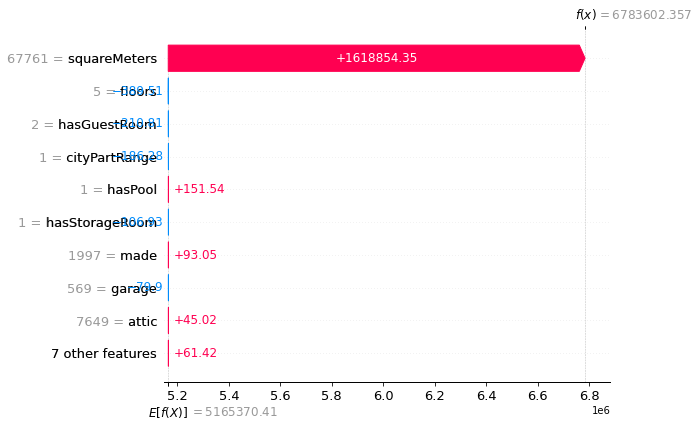

In [131]:
sample_feature_importance(0, 'waterfall')

In [132]:
shap.initjs()
sample_feature_importance(5, 'condensed')

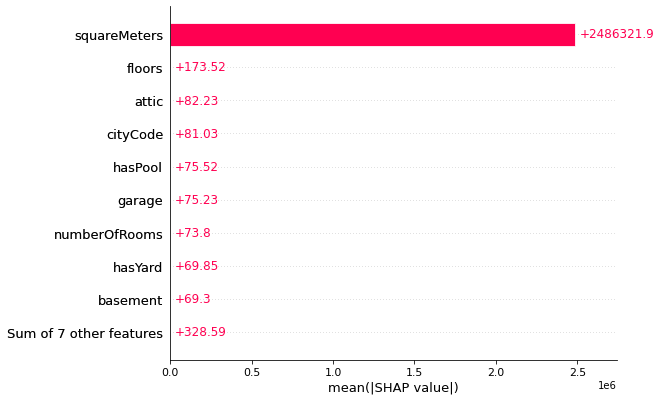

In [133]:
shap.plots.bar(shap_values)

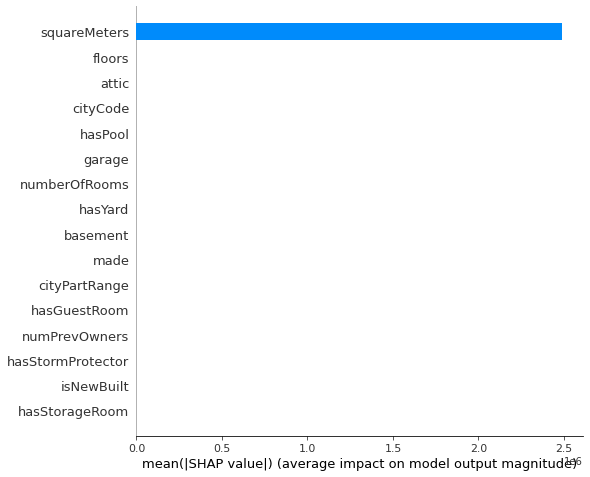

In [134]:
shap.summary_plot(shap_values.values, X_train, plot_type='bar')

We can see from the above plots that there is strong relationship between the independent variable squareMeters and target variable price.

### XGBoost - SHAP

In [135]:
from xgboost import XGBRegressor

df = pd.read_csv(url)
X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [136]:
my_imputer = SimpleImputer()
X_train = my_imputer.fit_transform(X_train)
X_test = my_imputer.transform(X_test)
X_test_df = pd.DataFrame(X_test)

In [137]:
#Training the model with XGBoost Regressor using the parameters from AutoML best model 
my_model = XGBRegressor(reg = 'linear', params = xgbparams)
hist = my_model.fit(X_train, y_train, 
                    early_stopping_rounds=5, 
                    eval_set=[(X_test, y_test)], eval_metric='rmse', 
                    verbose=100)

[23:48:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.14428e+06
Will train until validation_0-rmse hasn't improved in 5 rounds.
[99]	validation_0-rmse:20154.5


In [138]:
import shap
explainer = shap.TreeExplainer(my_model, feature_names = X.columns.values.tolist, class_names=['price'], verbose=True)
shap_values = explainer.shap_values(X_test_df)

In [139]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_df.iloc[0,:])

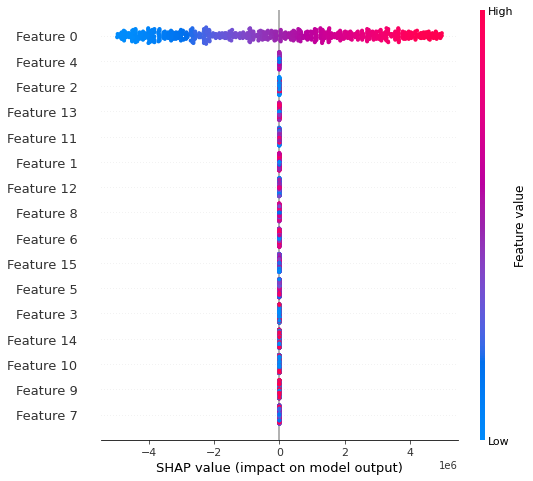

In [140]:
shap.summary_plot(shap_values, X_test)

In [141]:
df.columns.values

array(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage',
       'hasStorageRoom', 'hasGuestRoom', 'price'], dtype=object)

For the above sample on XGBoost Regressor, we can see that for the predicted price of 6789172.57, the squareMeters has a positive influence (i.e. higher the squareMeters value, the higher will be the price of the house). The no of floors has a negative influence on the house price and other variables have low impact on the result.  

### Decision Tree - SHAP

In [142]:
df = pd.read_csv(url)
X = df.drop('price',axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [143]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

texplainer = shap.TreeExplainer(regressor)
shap_values = texplainer.shap_values(X_test)
shap_values

array([[  591165.21798117,        0.        ,        0.        , ...,
               0.        ,        0.        ,        0.        ],
       [ 3113944.31992216,        0.        ,        0.        , ...,
               0.        ,        0.        ,        0.        ],
       [-1880181.32732695,        0.        ,        0.        , ...,
               0.        ,        0.        ,        0.        ],
       ...,
       [ 3113944.31992216,        0.        ,        0.        , ...,
               0.        ,        0.        ,        0.        ],
       [  591165.21798117,        0.        ,        0.        , ...,
               0.        ,        0.        ,        0.        ],
       [-4402158.5028558 ,        0.        ,        0.        , ...,
               0.        ,        0.        ,        0.        ]])

In [144]:
shap.initjs()
shap.force_plot(texplainer.expected_value, shap_values[0], X_test.iloc[0])

For the above sample, we can see that for the decision tree model, squareMeters has the highly positive impact on the values of house prices. Other variables have no impact for the prediction.

### Linear Regression - SHAP

In [145]:
df = pd.read_csv(url)
X = df.drop('price',axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [146]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [147]:
y_pred = model.predict(X_test)

In [148]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)**(0.5)
mse

1918.1933250908648

In [149]:
X100 = shap.utils.sample(X, 100)

explainer = shap.Explainer(model.predict,X100)
shap_values = explainer(X)

Permutation explainer: 10001it [09:32, 17.21it/s]


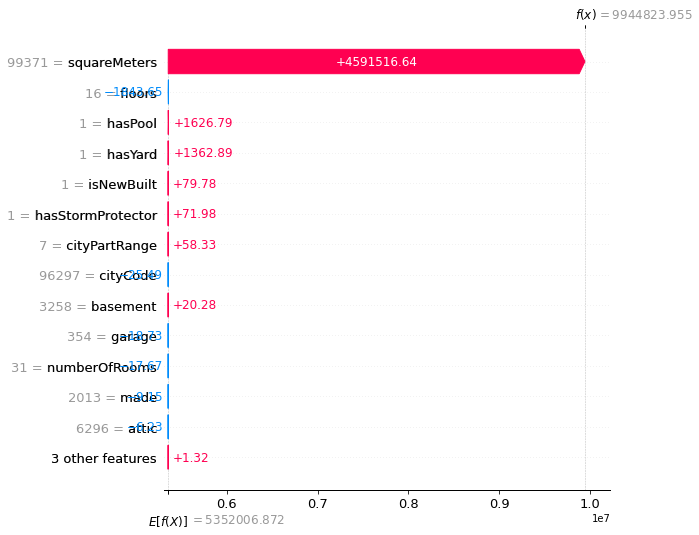

In [150]:
sample_ind = 17
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

For the above sample, we can see that for the linear model, squareMeters has the highest positive influence on the values of house prices. The predictors hasPool and hasYard also have a positive influence. Other predictors have low impact on the house prices. 

### Decision Tree - LIME

In [151]:
import lime
from pandas.core.frame import DataFrame
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

df = pd.read_csv(url)
X = df.drop('price',axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [152]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=6, random_state=0)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, random_state=0)

In [153]:
y_pred = model.predict(X_test)

In [154]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)**(0.5)
mse

45751.43342191601

In [155]:
import lime
import lime.lime_tabular

In [156]:
# LIME has one explainer for all the models
explainer_decisiontree = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                  verbose=True, mode='regression')

In [157]:
j = 8
exprf = explainer_decisiontree.explain_instance(X_test.values[j], model.predict, num_features=16)

Intercept 3758905.823020121
Prediction_local [8570427.56306142]
Right: 8973513.586507937


In [158]:
# Show the predictions
exprf.show_in_notebook(show_table=True)

For the above sample, for Decision Tree, we can see that the squareMeters (area of the house) has a huge positive impact on the prediction of the house prices. The predictor isNewBuilt also has a positive impact on the house prices. Other predictors have little to no impact on the prediction for house prices.

### Linear Regression - LIME

In [159]:
df = pd.read_csv(url)
X = df.drop('price',axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [160]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [161]:
y_pred = model.predict(X_test)

In [162]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)**(0.5)
mse

1918.1933250908648

In [163]:
explainer_linear = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                verbose=True, mode='regression')

In [164]:
j = 19
explinear = explainer_linear.explain_instance(X_test.values[j], model.predict, num_features=16)

Intercept 4683446.150543287
Prediction_local [5982367.6310119]
Right: 6813008.068887467


In [165]:
# Show the predictions
explinear.show_in_notebook(show_table=True)

For the linear model, the predicted house price for the sample is 6813008.07. 
The squareMeters, cityPartRange, the year when house was built and storm protector have positive influence on the prediction. 
The predictors hasStorageRoom, hasPool and numberOfRooms have negative influence on the predicted value.

### XGBoost - LIME

In [166]:
from xgboost import XGBRegressor

df = pd.read_csv(url)
X = df.drop('price',axis=1).select_dtypes(exclude=['object'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [167]:
my_imputer = SimpleImputer()
X_train = my_imputer.fit_transform(X_train)
X_test = my_imputer.transform(X_test)

In [168]:
my_model = XGBRegressor(reg = 'linear', params = xgbparams)
hist = my_model.fit(X_train, y_train, 
                    early_stopping_rounds=5, 
                    eval_set=[(X_test, y_test)], eval_metric='rmse', 
                    verbose=100)

[23:58:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.17342e+06
Will train until validation_0-rmse hasn't improved in 5 rounds.
[99]	validation_0-rmse:20365.5


In [169]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X.columns, class_names=['price'], verbose=True, mode='regression')

In [170]:
i = 10
expxgb = explainer.explain_instance(X_test[i], my_model.predict, num_features=10)
expxgb.show_in_notebook(show_table=True)

Intercept 3791346.465351898
Prediction_local [8599674.89531853]
Right: 9038634.0


For XGBoost, the predicted house price is 9038634.0. We can see that the area of the house and zipcode have a postive impact on the prediction whereas the number of floors has a negative impact. Other predictors have little to no impact on the prediction for house prices.

# Conclusion

For the Paris Housing dataset, the selected best model XGBOOST provides significantly better RMSE, MSE and MAE values as compared to the other models. There is low correlation between the predictor variables and no autocorrelation that exists. There is no improvement seen in the RSME values by tuning the hyperparameters and more exploration is needed for detecting the optimal hyperparameters. 
The dataset does not contain any missing values for any of the independent variables, and most of them seem to follow uniform distribution. From the OLS, XGBoost and Random Forest techniques, we can conclude that the independent variables squareMeters, floors, cityPartRange are the most important. Additionally, KNN seems to be the best performing imputation technique to recover the missing data. Removing outliers has positive impact on the RSME values for XGBoost regressor which was selected as best model by AutoML for this dataset.
SHAP (Shapley Additive Explanations) and LIME (Local Interpretable Model-Agnostic Explanations) are model agnostic methods which explain the prediction of an instance by computing the contribution of each feature to the prediction. From the above SHAP/LIME analysis on the Paris Housing dataset using different models, we can see that the squareMeters area of the house has the highest influence on the prediction of the price.

# References


1. https://github.com/nikbearbrown/AI_Research_Group/blob/main/Kaggle_Datasets/AutoML/VAI_Churn_H2O_automl.ipynb
2. https://www.kaggle.com/jiangqiz/final-project
3. https://www.datacamp.com/community/tutorials/xgboost-in-python
4. https://towardsdatascience.com/everything-you-need-to-know-about-multicollinearity-2f21f082d6dc
5. https://towardsdatascience.com/mastering-xgboost-2eb6bce6bc76
6. https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/xgboost.html
7. https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
8. https://coderzcolumn.com/tutorials/machine-learning/xgboost-an-in-depth-guide-python
9.   https://github.com/ajhalthor/model-interpretability/blob/main/Shap%20Values.ipynb
10.   https://www.viralml.com/video-content.html?v=ZkIxZ5xlMuI
11. https://www.kaggle.com/code/prashant111/explain-your-model-predictions-with-lime/notebook
12. https://coderzcolumn.com/tutorials/machine-learning/how-to-use-lime-to-understand-sklearn-models-predictions
13. https://www.analyticsvidhya.com/blog/2017/06/building-trust-in-machine-learning-models/
14. https://blog.dominodatalab.com/shap-lime-python-libraries-part-2-using-shap-lime#:~:text=XGBoost%20LIME
15. https://colab.research.google.com/drive/18Ucw2g9U1kwQIhalRL-MXbKTdqRdRn24?usp=sharing#scrollTo=4zsjZU4chJ6O
16. https://www.statology.org/how-to-calculate-vif-in-python/
17. https://www.kaggle.com/jiangqiz/final-project
18. https://www.yourdatateacher.com/2021/06/21/how-to-use-q-q-plot-for-checking-the-distribution-of-our-data/
19. https://www.analyticsvidhya.com/blog/2021/09/q-q-plot-ensure-your-ml-model-is-based-on-the-right-distributions/
20. https://towardsdatascience.com/3-essential-ways-to-calculate-feature-importance-in-python-2f9149592155

MIT License

Copyright (c) 2022 Aniket Mirajkar

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.